In [80]:
import numpy as np
import xgboost as xgb
import pandas as pd
from IPython.display import display #方便对数据进行可视化
import time
import datetime
from matplotlib import pyplot

In [81]:
def rmspe(y, y_hat):
    #由于sales取了对数，这里要还原
    y = np.exp(y)
    y_hat = np.exp(y_hat)
    
    #由于有yi=0的情况，直接计算会得出无穷大的结果，所以需要处理一下
    #定义一个y_rev来表示y的倒数，y为0时y_rev也赋值为0（因为在项目中提到“ Any day and store with 0 sales is ignored in scoring.“）
    y_rev = np.zeros(y.shape, dtype = float)
    n_zero = y != 0
    y_rev[n_zero] = 1./y[n_zero]

    rmspe = np.sqrt(np.mean(((y - y_hat)*y_rev)**2))
    return rmspe


#自定义一个评价函数

def rmspe_feval(y_hat, dy):
    y = dy.get_label()
    rmspe_score = rmspe(y, y_hat)
    return 'rmspe', rmspe_score


#定义训练函数
def train(param, dtrain, dval, num_round, feval_c, stopping):
    train_time = time.clock()

    model = xgb.train(
        param, dtrain, num_round, feval = feval_c, 
        evals = [(dtrain, 'train'), (dval, 'val')], early_stopping_rounds = stopping, 
        verbose_eval = True
    )

    train_time = time.clock() - train_time

    print('The training time of the model is: {:.0f}s'.format(train_time))
    
    return model

#定义一个打分函数
def score(bst, dval):
    y_pred = bst.predict(dval)
#print(y_pred)
    y_val = dval.get_label()
    score = rmspe(y_val, y_pred)
#print(score)
    print('The rmspe of the model on validation data set is {:.6f}'.format(score))
    pass

In [82]:
#从头开始处理数据

# 导入训练数据
train_data = pd.read_csv(
    "train.csv", 
    low_memory=False)

store_features = pd.read_csv("store.csv")
# 导入测试数据
test_data = pd.read_csv("test.csv")

train_data['year'] = train_data['Date'].apply(lambda x: float(x.split('-')[0]))
train_data['month'] = train_data['Date'].apply(lambda x: float(x.split('-')[1]))
train_data['day'] = train_data['Date'].apply(lambda x: float(x.split('-')[2]))

test_data['year'] = test_data['Date'].apply(lambda x: float(x.split('-')[0]))
test_data['month'] = test_data['Date'].apply(lambda x: float(x.split('-')[1]))
test_data['day'] = test_data['Date'].apply(lambda x: float(x.split('-')[2]))




In [83]:
#此处增加一步，先将验证集划分出来，用训练集的最后2周作为验证集
#打开数据文件，很容易找到，2015/7/18-2015/7/31时间范围内的数据编号为1 - 15611

val_data = train_data[: 15610]
train_data = train_data[15610:]

#只使用Open和销售不为0的数据
val_data = val_data[(val_data['Open'] == 1) & (val_data['Sales'] != 0)]
train_data = train_data[(train_data['Open'] == 1) & (train_data['Sales'] != 0)]


#融合
train_data = pd.merge(train_data, store_features, on = 'Store')
val_data = pd.merge(val_data, store_features, on = 'Store')
test_data = pd.merge(test_data, store_features, on = 'Store')

train_data = train_data.drop('Customers', axis = 1)
sales_train = train_data['Sales']
features_train = train_data.drop('Sales', axis = 1)

val_data = val_data.drop('Customers', axis = 1)
sales_val = val_data['Sales']
features_val = val_data.drop('Sales', axis = 1)

features_test = test_data.drop('Id', axis = 1)

# 对字符串特征进行独热编码
category = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']


#首先将训练集、验证集、测试集合并，然后统一独热编码，然后再拆分为训练集、验证集、测试集

print('合并前：')
print(features_train.shape[0])
print(features_val.shape[0])
print(features_test.shape[0])

data_merge = pd.concat([features_train, features_val], ignore_index = True)
data_merge = pd.concat([data_merge, features_test], ignore_index = True)
data_merge_pd = pd.get_dummies(data_merge, columns = category)

#把时间数据转化为一年中的第几周

data_merge_pd['Date'] = pd.to_datetime(data_merge_pd['Date'])
data_merge_pd['weekofyear'] = data_merge_pd['Date'].dt.weekofyear
data_merge_pd = data_merge_pd.drop('Date', axis = 1)

# 需要把NA/NAN的数据转化成0
data_merge_pd.fillna(0, inplace = True)


#拆分

features_train = data_merge_pd[ : features_train.shape[0]]
features_val = data_merge_pd[features_train.shape[0] : (features_val.shape[0] + features_train.shape[0])]
features_test = data_merge_pd[ (features_val.shape[0] + features_train.shape[0]) : ]

print('合并后：')
print(features_train.shape[0])
print(features_val.shape[0])
print(features_test.shape[0])



#下面将sales做log处理

sales_train_log = np.log(sales_train) #因为去掉了为0的销售数据，所以不用+1了
sales_val_log = np.log(sales_val)

dtrain = xgb.DMatrix(features_train, label = sales_train_log)

dval = xgb.DMatrix(features_val, label = sales_val_log)





合并前：
830918
13420
41088
合并后：
830918
13420
41088


In [84]:
#设定参数
param = {'max_depth': 9, 'eta': 0.04, 'silent': 0, 'objective': 'reg:linear', 'min_child_weight': 6, 'colsample_bytree': 0.3, 'subsample':0.3}
#设定迭代次数

num_round = 100000
stopping = 150

#训练并打分
model = train(param, dtrain, dval, num_round, rmspe_feval, stopping)
score(model, dval)

[0]	train-rmse:7.93857	val-rmse:7.94388	train-rmspe:0.999604	val-rmspe:0.999608
Multiple eval metrics have been passed: 'val-rmspe' will be used for early stopping.

Will train until val-rmspe hasn't improved in 150 rounds.
[1]	train-rmse:7.62176	val-rmse:7.62795	train-rmspe:0.999457	val-rmspe:0.999463
[2]	train-rmse:7.31771	val-rmse:7.32359	train-rmspe:0.999265	val-rmspe:0.999272
[3]	train-rmse:7.02596	val-rmse:7.03241	train-rmspe:0.999016	val-rmspe:0.999026
[4]	train-rmse:6.74582	val-rmse:6.75206	train-rmspe:0.998698	val-rmspe:0.998711
[5]	train-rmse:6.47694	val-rmse:6.4832	train-rmspe:0.998298	val-rmspe:0.998315
[6]	train-rmse:6.21873	val-rmse:6.22517	train-rmspe:0.997798	val-rmspe:0.997821
[7]	train-rmse:5.97103	val-rmse:5.97713	train-rmspe:0.997179	val-rmspe:0.997208
[8]	train-rmse:5.73326	val-rmse:5.73918	train-rmspe:0.996423	val-rmspe:0.996459
[9]	train-rmse:5.50507	val-rmse:5.51145	train-rmspe:0.995506	val-rmspe:0.995553
[10]	train-rmse:5.28597	val-rmse:5.2928	train-rmspe:0.994

[99]	train-rmse:0.314996	val-rmse:0.309642	train-rmspe:0.316384	val-rmspe:0.282932
[100]	train-rmse:0.312	val-rmse:0.307032	train-rmspe:0.31595	val-rmspe:0.282334
[101]	train-rmse:0.3094	val-rmse:0.305127	train-rmspe:0.315905	val-rmspe:0.282057
[102]	train-rmse:0.307064	val-rmse:0.303053	train-rmspe:0.316036	val-rmspe:0.281825
[103]	train-rmse:0.304914	val-rmse:0.300619	train-rmspe:0.316166	val-rmspe:0.281494
[104]	train-rmse:0.302319	val-rmse:0.298154	train-rmspe:0.315758	val-rmspe:0.280869
[105]	train-rmse:0.300383	val-rmse:0.296069	train-rmspe:0.316012	val-rmspe:0.28069
[106]	train-rmse:0.29803	val-rmse:0.293669	train-rmspe:0.315577	val-rmspe:0.279936
[107]	train-rmse:0.296405	val-rmse:0.292065	train-rmspe:0.315801	val-rmspe:0.279957
[108]	train-rmse:0.294663	val-rmse:0.290412	train-rmspe:0.315882	val-rmspe:0.279812
[109]	train-rmse:0.291859	val-rmse:0.288244	train-rmspe:0.314848	val-rmspe:0.279201
[110]	train-rmse:0.289903	val-rmse:0.286421	train-rmspe:0.314643	val-rmspe:0.278778
[

[198]	train-rmse:0.228475	val-rmse:0.232554	train-rmspe:0.291922	val-rmspe:0.25163
[199]	train-rmse:0.228246	val-rmse:0.23232	train-rmspe:0.291805	val-rmspe:0.25137
[200]	train-rmse:0.228162	val-rmse:0.232302	train-rmspe:0.291732	val-rmspe:0.251496
[201]	train-rmse:0.227811	val-rmse:0.232044	train-rmspe:0.291459	val-rmspe:0.251231
[202]	train-rmse:0.227555	val-rmse:0.231789	train-rmspe:0.291307	val-rmspe:0.250997
[203]	train-rmse:0.226756	val-rmse:0.231024	train-rmspe:0.290723	val-rmspe:0.25012
[204]	train-rmse:0.226208	val-rmse:0.230602	train-rmspe:0.290063	val-rmspe:0.249635
[205]	train-rmse:0.225978	val-rmse:0.230501	train-rmspe:0.289902	val-rmspe:0.249291
[206]	train-rmse:0.225763	val-rmse:0.230363	train-rmspe:0.289775	val-rmspe:0.249038
[207]	train-rmse:0.225515	val-rmse:0.230173	train-rmspe:0.289547	val-rmspe:0.248856
[208]	train-rmse:0.225168	val-rmse:0.22985	train-rmspe:0.289339	val-rmspe:0.248516
[209]	train-rmse:0.224242	val-rmse:0.228968	train-rmspe:0.288485	val-rmspe:0.2475

[296]	train-rmse:0.18935	val-rmse:0.197956	train-rmspe:0.25387	val-rmspe:0.209941
[297]	train-rmse:0.187968	val-rmse:0.196676	train-rmspe:0.252582	val-rmspe:0.208343
[298]	train-rmse:0.187724	val-rmse:0.196496	train-rmspe:0.252324	val-rmspe:0.208098
[299]	train-rmse:0.187515	val-rmse:0.19631	train-rmspe:0.252186	val-rmspe:0.207841
[300]	train-rmse:0.187099	val-rmse:0.19583	train-rmspe:0.251736	val-rmspe:0.207187
[301]	train-rmse:0.187073	val-rmse:0.195808	train-rmspe:0.25173	val-rmspe:0.207139
[302]	train-rmse:0.186932	val-rmse:0.195636	train-rmspe:0.251569	val-rmspe:0.206921
[303]	train-rmse:0.186816	val-rmse:0.1955	train-rmspe:0.251498	val-rmspe:0.206818
[304]	train-rmse:0.186654	val-rmse:0.195325	train-rmspe:0.251367	val-rmspe:0.206642
[305]	train-rmse:0.18635	val-rmse:0.195111	train-rmspe:0.250997	val-rmspe:0.206427
[306]	train-rmse:0.186243	val-rmse:0.195046	train-rmspe:0.250901	val-rmspe:0.206365
[307]	train-rmse:0.186125	val-rmse:0.194925	train-rmspe:0.250777	val-rmspe:0.206224


[395]	train-rmse:0.167932	val-rmse:0.179146	train-rmspe:0.232728	val-rmspe:0.18739
[396]	train-rmse:0.167255	val-rmse:0.178557	train-rmspe:0.232044	val-rmspe:0.18669
[397]	train-rmse:0.167238	val-rmse:0.178515	train-rmspe:0.232016	val-rmspe:0.186654
[398]	train-rmse:0.167193	val-rmse:0.178493	train-rmspe:0.231987	val-rmspe:0.186615
[399]	train-rmse:0.166779	val-rmse:0.178078	train-rmspe:0.231678	val-rmspe:0.186163
[400]	train-rmse:0.166741	val-rmse:0.178006	train-rmspe:0.231631	val-rmspe:0.186082
[401]	train-rmse:0.166591	val-rmse:0.177805	train-rmspe:0.231463	val-rmspe:0.185898
[402]	train-rmse:0.166485	val-rmse:0.177714	train-rmspe:0.231364	val-rmspe:0.185786
[403]	train-rmse:0.165742	val-rmse:0.177039	train-rmspe:0.230707	val-rmspe:0.185001
[404]	train-rmse:0.165687	val-rmse:0.17698	train-rmspe:0.230624	val-rmspe:0.184828
[405]	train-rmse:0.165242	val-rmse:0.17655	train-rmspe:0.23025	val-rmspe:0.184307
[406]	train-rmse:0.165123	val-rmse:0.176521	train-rmspe:0.230103	val-rmspe:0.1840

[493]	train-rmse:0.149888	val-rmse:0.162584	train-rmspe:0.216113	val-rmspe:0.167631
[494]	train-rmse:0.149817	val-rmse:0.162506	train-rmspe:0.216067	val-rmspe:0.16758
[495]	train-rmse:0.149762	val-rmse:0.162527	train-rmspe:0.216028	val-rmspe:0.167505
[496]	train-rmse:0.149753	val-rmse:0.162528	train-rmspe:0.216018	val-rmspe:0.167506
[497]	train-rmse:0.149745	val-rmse:0.162522	train-rmspe:0.216019	val-rmspe:0.167506
[498]	train-rmse:0.149721	val-rmse:0.162527	train-rmspe:0.215972	val-rmspe:0.167506
[499]	train-rmse:0.149649	val-rmse:0.162476	train-rmspe:0.215901	val-rmspe:0.167435
[500]	train-rmse:0.149341	val-rmse:0.16223	train-rmspe:0.215694	val-rmspe:0.167194
[501]	train-rmse:0.149333	val-rmse:0.162213	train-rmspe:0.215679	val-rmspe:0.167156
[502]	train-rmse:0.149034	val-rmse:0.16196	train-rmspe:0.215388	val-rmspe:0.166875
[503]	train-rmse:0.149013	val-rmse:0.161943	train-rmspe:0.215356	val-rmspe:0.166873
[504]	train-rmse:0.148957	val-rmse:0.161935	train-rmspe:0.215327	val-rmspe:0.16

[592]	train-rmse:0.138751	val-rmse:0.152939	train-rmspe:0.205533	val-rmspe:0.155983
[593]	train-rmse:0.138446	val-rmse:0.152701	train-rmspe:0.205198	val-rmspe:0.155702
[594]	train-rmse:0.138203	val-rmse:0.152493	train-rmspe:0.204961	val-rmspe:0.155433
[595]	train-rmse:0.138091	val-rmse:0.152424	train-rmspe:0.205122	val-rmspe:0.155363
[596]	train-rmse:0.138082	val-rmse:0.152415	train-rmspe:0.205115	val-rmspe:0.155352
[597]	train-rmse:0.137987	val-rmse:0.152314	train-rmspe:0.205072	val-rmspe:0.155232
[598]	train-rmse:0.137767	val-rmse:0.152094	train-rmspe:0.204909	val-rmspe:0.154985
[599]	train-rmse:0.137713	val-rmse:0.152061	train-rmspe:0.204855	val-rmspe:0.154928
[600]	train-rmse:0.137545	val-rmse:0.151928	train-rmspe:0.20462	val-rmspe:0.154773
[601]	train-rmse:0.137437	val-rmse:0.15183	train-rmspe:0.204528	val-rmspe:0.154652
[602]	train-rmse:0.137425	val-rmse:0.151791	train-rmspe:0.204526	val-rmspe:0.154648
[603]	train-rmse:0.137419	val-rmse:0.151787	train-rmspe:0.204526	val-rmspe:0.1

[691]	train-rmse:0.130537	val-rmse:0.145265	train-rmspe:0.198297	val-rmspe:0.147007
[692]	train-rmse:0.130512	val-rmse:0.145243	train-rmspe:0.198262	val-rmspe:0.146983
[693]	train-rmse:0.130361	val-rmse:0.145124	train-rmspe:0.198143	val-rmspe:0.146857
[694]	train-rmse:0.130317	val-rmse:0.145168	train-rmspe:0.198081	val-rmspe:0.146816
[695]	train-rmse:0.130269	val-rmse:0.145145	train-rmspe:0.198101	val-rmspe:0.14678
[696]	train-rmse:0.130219	val-rmse:0.145118	train-rmspe:0.198064	val-rmspe:0.146751
[697]	train-rmse:0.130212	val-rmse:0.145107	train-rmspe:0.198056	val-rmspe:0.146743
[698]	train-rmse:0.130176	val-rmse:0.145022	train-rmspe:0.198008	val-rmspe:0.146688
[699]	train-rmse:0.130162	val-rmse:0.14501	train-rmspe:0.197987	val-rmspe:0.146674
[700]	train-rmse:0.130045	val-rmse:0.144903	train-rmspe:0.197899	val-rmspe:0.14656
[701]	train-rmse:0.130017	val-rmse:0.144867	train-rmspe:0.19789	val-rmspe:0.14652
[702]	train-rmse:0.130006	val-rmse:0.144835	train-rmspe:0.197904	val-rmspe:0.1464

[789]	train-rmse:0.125404	val-rmse:0.140213	train-rmspe:0.193158	val-rmspe:0.141511
[790]	train-rmse:0.125273	val-rmse:0.140084	train-rmspe:0.193051	val-rmspe:0.141368
[791]	train-rmse:0.125235	val-rmse:0.140043	train-rmspe:0.193023	val-rmspe:0.141326
[792]	train-rmse:0.125194	val-rmse:0.140031	train-rmspe:0.192974	val-rmspe:0.141323
[793]	train-rmse:0.125191	val-rmse:0.140022	train-rmspe:0.192976	val-rmspe:0.141319
[794]	train-rmse:0.125154	val-rmse:0.139981	train-rmspe:0.192947	val-rmspe:0.141276
[795]	train-rmse:0.125127	val-rmse:0.139963	train-rmspe:0.192922	val-rmspe:0.141193
[796]	train-rmse:0.125039	val-rmse:0.139891	train-rmspe:0.192885	val-rmspe:0.141124
[797]	train-rmse:0.125026	val-rmse:0.13989	train-rmspe:0.192873	val-rmspe:0.141117
[798]	train-rmse:0.124997	val-rmse:0.139941	train-rmspe:0.192806	val-rmspe:0.141188
[799]	train-rmse:0.12495	val-rmse:0.139892	train-rmspe:0.192743	val-rmspe:0.14113
[800]	train-rmse:0.124936	val-rmse:0.139868	train-rmspe:0.192742	val-rmspe:0.14

[887]	train-rmse:0.121034	val-rmse:0.136274	train-rmspe:0.187914	val-rmspe:0.137443
[888]	train-rmse:0.121025	val-rmse:0.136276	train-rmspe:0.187869	val-rmspe:0.137452
[889]	train-rmse:0.120969	val-rmse:0.136207	train-rmspe:0.187831	val-rmspe:0.137382
[890]	train-rmse:0.120944	val-rmse:0.136135	train-rmspe:0.187813	val-rmspe:0.137319
[891]	train-rmse:0.120933	val-rmse:0.136121	train-rmspe:0.187808	val-rmspe:0.137304
[892]	train-rmse:0.120923	val-rmse:0.136118	train-rmspe:0.1878	val-rmspe:0.137293
[893]	train-rmse:0.120876	val-rmse:0.13607	train-rmspe:0.187125	val-rmspe:0.137232
[894]	train-rmse:0.120841	val-rmse:0.136037	train-rmspe:0.187089	val-rmspe:0.137193
[895]	train-rmse:0.120728	val-rmse:0.135943	train-rmspe:0.186992	val-rmspe:0.137086
[896]	train-rmse:0.120665	val-rmse:0.135882	train-rmspe:0.186938	val-rmspe:0.137017
[897]	train-rmse:0.120641	val-rmse:0.135825	train-rmspe:0.186906	val-rmspe:0.136985
[898]	train-rmse:0.120563	val-rmse:0.135755	train-rmspe:0.186862	val-rmspe:0.13

[985]	train-rmse:0.117451	val-rmse:0.132918	train-rmspe:0.183601	val-rmspe:0.133883
[986]	train-rmse:0.117441	val-rmse:0.132907	train-rmspe:0.183541	val-rmspe:0.133877
[987]	train-rmse:0.117319	val-rmse:0.132805	train-rmspe:0.183412	val-rmspe:0.133749
[988]	train-rmse:0.117292	val-rmse:0.132778	train-rmspe:0.183394	val-rmspe:0.133721
[989]	train-rmse:0.117244	val-rmse:0.132739	train-rmspe:0.183351	val-rmspe:0.133677
[990]	train-rmse:0.117222	val-rmse:0.132717	train-rmspe:0.183324	val-rmspe:0.133633
[991]	train-rmse:0.117222	val-rmse:0.132714	train-rmspe:0.183327	val-rmspe:0.133635
[992]	train-rmse:0.117109	val-rmse:0.13264	train-rmspe:0.183226	val-rmspe:0.133547
[993]	train-rmse:0.117061	val-rmse:0.132594	train-rmspe:0.183179	val-rmspe:0.133499
[994]	train-rmse:0.116992	val-rmse:0.132529	train-rmspe:0.183129	val-rmspe:0.133427
[995]	train-rmse:0.116953	val-rmse:0.132482	train-rmspe:0.183081	val-rmspe:0.133383
[996]	train-rmse:0.11693	val-rmse:0.132459	train-rmspe:0.183068	val-rmspe:0.1

[1083]	train-rmse:0.114513	val-rmse:0.13025	train-rmspe:0.180296	val-rmspe:0.130907
[1084]	train-rmse:0.114508	val-rmse:0.13025	train-rmspe:0.180296	val-rmspe:0.130907
[1085]	train-rmse:0.114497	val-rmse:0.130235	train-rmspe:0.180286	val-rmspe:0.13089
[1086]	train-rmse:0.114489	val-rmse:0.130231	train-rmspe:0.180275	val-rmspe:0.13088
[1087]	train-rmse:0.11447	val-rmse:0.130212	train-rmspe:0.180254	val-rmspe:0.130862
[1088]	train-rmse:0.114441	val-rmse:0.130172	train-rmspe:0.180246	val-rmspe:0.130826
[1089]	train-rmse:0.114419	val-rmse:0.130135	train-rmspe:0.180237	val-rmspe:0.13079
[1090]	train-rmse:0.11439	val-rmse:0.130089	train-rmspe:0.180222	val-rmspe:0.13075
[1091]	train-rmse:0.114384	val-rmse:0.130094	train-rmspe:0.180214	val-rmspe:0.130753
[1092]	train-rmse:0.114379	val-rmse:0.130073	train-rmspe:0.180215	val-rmspe:0.130733
[1093]	train-rmse:0.114368	val-rmse:0.130056	train-rmspe:0.180202	val-rmspe:0.130722
[1094]	train-rmse:0.114333	val-rmse:0.130027	train-rmspe:0.180167	val-rms

[1180]	train-rmse:0.112457	val-rmse:0.128319	train-rmspe:0.177629	val-rmspe:0.128803
[1181]	train-rmse:0.112423	val-rmse:0.128285	train-rmspe:0.177595	val-rmspe:0.128763
[1182]	train-rmse:0.112401	val-rmse:0.128282	train-rmspe:0.177583	val-rmspe:0.128754
[1183]	train-rmse:0.112369	val-rmse:0.128258	train-rmspe:0.17759	val-rmspe:0.128728
[1184]	train-rmse:0.11236	val-rmse:0.128259	train-rmspe:0.177576	val-rmspe:0.128723
[1185]	train-rmse:0.112357	val-rmse:0.128256	train-rmspe:0.177575	val-rmspe:0.128726
[1186]	train-rmse:0.112343	val-rmse:0.128239	train-rmspe:0.177573	val-rmspe:0.128711
[1187]	train-rmse:0.112334	val-rmse:0.128231	train-rmspe:0.177567	val-rmspe:0.128704
[1188]	train-rmse:0.112318	val-rmse:0.128211	train-rmspe:0.177548	val-rmspe:0.128684
[1189]	train-rmse:0.112308	val-rmse:0.128208	train-rmspe:0.177536	val-rmspe:0.128676
[1190]	train-rmse:0.11228	val-rmse:0.128175	train-rmspe:0.177504	val-rmspe:0.128638
[1191]	train-rmse:0.11217	val-rmse:0.128094	train-rmspe:0.177361	val

[1277]	train-rmse:0.110251	val-rmse:0.12626	train-rmspe:0.174797	val-rmspe:0.126675
[1278]	train-rmse:0.110247	val-rmse:0.126246	train-rmspe:0.174798	val-rmspe:0.126668
[1279]	train-rmse:0.110179	val-rmse:0.126191	train-rmspe:0.174757	val-rmspe:0.126606
[1280]	train-rmse:0.110064	val-rmse:0.126117	train-rmspe:0.174733	val-rmspe:0.126514
[1281]	train-rmse:0.110015	val-rmse:0.126082	train-rmspe:0.174654	val-rmspe:0.126476
[1282]	train-rmse:0.110008	val-rmse:0.126083	train-rmspe:0.174646	val-rmspe:0.126478
[1283]	train-rmse:0.110004	val-rmse:0.126081	train-rmspe:0.174644	val-rmspe:0.126476
[1284]	train-rmse:0.110003	val-rmse:0.126077	train-rmspe:0.174642	val-rmspe:0.126472
[1285]	train-rmse:0.10999	val-rmse:0.12607	train-rmspe:0.174634	val-rmspe:0.126456
[1286]	train-rmse:0.109978	val-rmse:0.126065	train-rmspe:0.174631	val-rmspe:0.126452
[1287]	train-rmse:0.109971	val-rmse:0.12605	train-rmspe:0.174631	val-rmspe:0.126434
[1288]	train-rmse:0.109894	val-rmse:0.126003	train-rmspe:0.174565	val

[1374]	train-rmse:0.108319	val-rmse:0.124475	train-rmspe:0.171547	val-rmspe:0.1248
[1375]	train-rmse:0.108306	val-rmse:0.124458	train-rmspe:0.171554	val-rmspe:0.124789
[1376]	train-rmse:0.108295	val-rmse:0.124458	train-rmspe:0.17153	val-rmspe:0.124786
[1377]	train-rmse:0.108278	val-rmse:0.124428	train-rmspe:0.171508	val-rmspe:0.124769
[1378]	train-rmse:0.108213	val-rmse:0.124372	train-rmspe:0.171459	val-rmspe:0.12471
[1379]	train-rmse:0.108133	val-rmse:0.124304	train-rmspe:0.171339	val-rmspe:0.124635
[1380]	train-rmse:0.108115	val-rmse:0.124229	train-rmspe:0.171332	val-rmspe:0.124557
[1381]	train-rmse:0.108093	val-rmse:0.124205	train-rmspe:0.171311	val-rmspe:0.124531
[1382]	train-rmse:0.10809	val-rmse:0.124206	train-rmspe:0.171301	val-rmspe:0.124525
[1383]	train-rmse:0.108072	val-rmse:0.124177	train-rmspe:0.171288	val-rmspe:0.124492
[1384]	train-rmse:0.108071	val-rmse:0.124178	train-rmspe:0.171279	val-rmspe:0.124498
[1385]	train-rmse:0.108068	val-rmse:0.124173	train-rmspe:0.171279	val-

[1471]	train-rmse:0.106768	val-rmse:0.123184	train-rmspe:0.169967	val-rmspe:0.123378
[1472]	train-rmse:0.106757	val-rmse:0.123177	train-rmspe:0.169949	val-rmspe:0.123371
[1473]	train-rmse:0.106752	val-rmse:0.123168	train-rmspe:0.169947	val-rmspe:0.123362
[1474]	train-rmse:0.106736	val-rmse:0.123172	train-rmspe:0.169934	val-rmspe:0.123344
[1475]	train-rmse:0.106731	val-rmse:0.123168	train-rmspe:0.169924	val-rmspe:0.123337
[1476]	train-rmse:0.106707	val-rmse:0.123156	train-rmspe:0.169913	val-rmspe:0.123321
[1477]	train-rmse:0.10668	val-rmse:0.12314	train-rmspe:0.169886	val-rmspe:0.123304
[1478]	train-rmse:0.106677	val-rmse:0.123138	train-rmspe:0.169879	val-rmspe:0.123301
[1479]	train-rmse:0.10667	val-rmse:0.123129	train-rmspe:0.169876	val-rmspe:0.123286
[1480]	train-rmse:0.106649	val-rmse:0.123091	train-rmspe:0.169864	val-rmspe:0.123251
[1481]	train-rmse:0.106643	val-rmse:0.123091	train-rmspe:0.169857	val-rmspe:0.123246
[1482]	train-rmse:0.10664	val-rmse:0.123084	train-rmspe:0.169852	val

[1568]	train-rmse:0.105325	val-rmse:0.122105	train-rmspe:0.168682	val-rmspe:0.122202
[1569]	train-rmse:0.105323	val-rmse:0.122101	train-rmspe:0.168682	val-rmspe:0.122195
[1570]	train-rmse:0.105311	val-rmse:0.122085	train-rmspe:0.168672	val-rmspe:0.122179
[1571]	train-rmse:0.105291	val-rmse:0.122071	train-rmspe:0.168771	val-rmspe:0.122168
[1572]	train-rmse:0.105234	val-rmse:0.122045	train-rmspe:0.168727	val-rmspe:0.122136
[1573]	train-rmse:0.105233	val-rmse:0.122042	train-rmspe:0.168727	val-rmspe:0.122134
[1574]	train-rmse:0.105224	val-rmse:0.122019	train-rmspe:0.168764	val-rmspe:0.122123
[1575]	train-rmse:0.10521	val-rmse:0.121992	train-rmspe:0.168755	val-rmspe:0.122093
[1576]	train-rmse:0.105186	val-rmse:0.121942	train-rmspe:0.168728	val-rmspe:0.122057
[1577]	train-rmse:0.105144	val-rmse:0.121868	train-rmspe:0.168699	val-rmspe:0.121992
[1578]	train-rmse:0.105138	val-rmse:0.121863	train-rmspe:0.168688	val-rmspe:0.121987
[1579]	train-rmse:0.105124	val-rmse:0.121838	train-rmspe:0.168693	

[1665]	train-rmse:0.103636	val-rmse:0.120838	train-rmspe:0.166281	val-rmspe:0.120888
[1666]	train-rmse:0.103578	val-rmse:0.120788	train-rmspe:0.16622	val-rmspe:0.120832
[1667]	train-rmse:0.103558	val-rmse:0.120773	train-rmspe:0.166206	val-rmspe:0.120816
[1668]	train-rmse:0.103553	val-rmse:0.120793	train-rmspe:0.166166	val-rmspe:0.120838
[1669]	train-rmse:0.103553	val-rmse:0.120792	train-rmspe:0.166167	val-rmspe:0.120836
[1670]	train-rmse:0.10355	val-rmse:0.120788	train-rmspe:0.166161	val-rmspe:0.120835
[1671]	train-rmse:0.103493	val-rmse:0.120732	train-rmspe:0.166124	val-rmspe:0.120779
[1672]	train-rmse:0.103485	val-rmse:0.120729	train-rmspe:0.166128	val-rmspe:0.120773
[1673]	train-rmse:0.103482	val-rmse:0.120734	train-rmspe:0.16613	val-rmspe:0.120777
[1674]	train-rmse:0.103474	val-rmse:0.120724	train-rmspe:0.166128	val-rmspe:0.120768
[1675]	train-rmse:0.103462	val-rmse:0.120725	train-rmspe:0.16613	val-rmspe:0.120763
[1676]	train-rmse:0.103438	val-rmse:0.120722	train-rmspe:0.166112	val

[1762]	train-rmse:0.102186	val-rmse:0.119955	train-rmspe:0.163005	val-rmspe:0.119879
[1763]	train-rmse:0.102174	val-rmse:0.119945	train-rmspe:0.163007	val-rmspe:0.119872
[1764]	train-rmse:0.102163	val-rmse:0.119948	train-rmspe:0.16299	val-rmspe:0.119878
[1765]	train-rmse:0.10215	val-rmse:0.119946	train-rmspe:0.162989	val-rmspe:0.119878
[1766]	train-rmse:0.102128	val-rmse:0.119944	train-rmspe:0.162946	val-rmspe:0.119867
[1767]	train-rmse:0.102126	val-rmse:0.119944	train-rmspe:0.162942	val-rmspe:0.119868
[1768]	train-rmse:0.102125	val-rmse:0.119943	train-rmspe:0.162936	val-rmspe:0.119864
[1769]	train-rmse:0.102118	val-rmse:0.119927	train-rmspe:0.16293	val-rmspe:0.119847
[1770]	train-rmse:0.102107	val-rmse:0.119938	train-rmspe:0.162923	val-rmspe:0.119853
[1771]	train-rmse:0.102085	val-rmse:0.119917	train-rmspe:0.162904	val-rmspe:0.119839
[1772]	train-rmse:0.102083	val-rmse:0.119908	train-rmspe:0.162901	val-rmspe:0.11983
[1773]	train-rmse:0.102072	val-rmse:0.119919	train-rmspe:0.16289	val-

[1859]	train-rmse:0.10103	val-rmse:0.119019	train-rmspe:0.159789	val-rmspe:0.119041
[1860]	train-rmse:0.101025	val-rmse:0.119018	train-rmspe:0.159792	val-rmspe:0.119039
[1861]	train-rmse:0.101025	val-rmse:0.119018	train-rmspe:0.159795	val-rmspe:0.119039
[1862]	train-rmse:0.101006	val-rmse:0.118965	train-rmspe:0.159777	val-rmspe:0.118978
[1863]	train-rmse:0.100979	val-rmse:0.118957	train-rmspe:0.159308	val-rmspe:0.118975
[1864]	train-rmse:0.100964	val-rmse:0.118921	train-rmspe:0.159306	val-rmspe:0.11895
[1865]	train-rmse:0.100926	val-rmse:0.11889	train-rmspe:0.159261	val-rmspe:0.11892
[1866]	train-rmse:0.100899	val-rmse:0.118844	train-rmspe:0.159295	val-rmspe:0.118871
[1867]	train-rmse:0.10089	val-rmse:0.118833	train-rmspe:0.159276	val-rmspe:0.118864
[1868]	train-rmse:0.100874	val-rmse:0.118813	train-rmspe:0.158922	val-rmspe:0.11885
[1869]	train-rmse:0.100869	val-rmse:0.11879	train-rmspe:0.158919	val-rmspe:0.118858
[1870]	train-rmse:0.100867	val-rmse:0.11879	train-rmspe:0.158922	val-rms

[1957]	train-rmse:0.099921	val-rmse:0.118055	train-rmspe:0.157219	val-rmspe:0.118123
[1958]	train-rmse:0.099913	val-rmse:0.118046	train-rmspe:0.157215	val-rmspe:0.118112
[1959]	train-rmse:0.099893	val-rmse:0.118018	train-rmspe:0.156461	val-rmspe:0.118078
[1960]	train-rmse:0.099893	val-rmse:0.118019	train-rmspe:0.15646	val-rmspe:0.118078
[1961]	train-rmse:0.099885	val-rmse:0.117997	train-rmspe:0.156457	val-rmspe:0.118058
[1962]	train-rmse:0.099885	val-rmse:0.117991	train-rmspe:0.15645	val-rmspe:0.118053
[1963]	train-rmse:0.09987	val-rmse:0.117976	train-rmspe:0.15645	val-rmspe:0.118039
[1964]	train-rmse:0.099868	val-rmse:0.117976	train-rmspe:0.156464	val-rmspe:0.118035
[1965]	train-rmse:0.099864	val-rmse:0.117977	train-rmspe:0.156463	val-rmspe:0.118033
[1966]	train-rmse:0.099859	val-rmse:0.117973	train-rmspe:0.156462	val-rmspe:0.118031
[1967]	train-rmse:0.099854	val-rmse:0.117974	train-rmspe:0.156097	val-rmspe:0.118032
[1968]	train-rmse:0.099841	val-rmse:0.117962	train-rmspe:0.156104	val

[2054]	train-rmse:0.099084	val-rmse:0.117309	train-rmspe:0.155233	val-rmspe:0.117353
[2055]	train-rmse:0.099062	val-rmse:0.117335	train-rmspe:0.155211	val-rmspe:0.117373
[2056]	train-rmse:0.099056	val-rmse:0.117324	train-rmspe:0.155197	val-rmspe:0.117365
[2057]	train-rmse:0.099048	val-rmse:0.11732	train-rmspe:0.155131	val-rmspe:0.11737
[2058]	train-rmse:0.099041	val-rmse:0.117315	train-rmspe:0.155122	val-rmspe:0.117364
[2059]	train-rmse:0.099039	val-rmse:0.117329	train-rmspe:0.155111	val-rmspe:0.117372
[2060]	train-rmse:0.099032	val-rmse:0.117328	train-rmspe:0.155115	val-rmspe:0.117373
[2061]	train-rmse:0.099019	val-rmse:0.117328	train-rmspe:0.155113	val-rmspe:0.117372
[2062]	train-rmse:0.099007	val-rmse:0.117319	train-rmspe:0.155087	val-rmspe:0.117363
[2063]	train-rmse:0.098965	val-rmse:0.117287	train-rmspe:0.155058	val-rmspe:0.117328
[2064]	train-rmse:0.098937	val-rmse:0.11727	train-rmspe:0.15503	val-rmspe:0.117313
[2065]	train-rmse:0.098934	val-rmse:0.117272	train-rmspe:0.15503	val-

[2151]	train-rmse:0.09804	val-rmse:0.116548	train-rmspe:0.153104	val-rmspe:0.11657
[2152]	train-rmse:0.098035	val-rmse:0.116545	train-rmspe:0.15309	val-rmspe:0.116568
[2153]	train-rmse:0.098018	val-rmse:0.11655	train-rmspe:0.153065	val-rmspe:0.116566
[2154]	train-rmse:0.098015	val-rmse:0.116539	train-rmspe:0.153069	val-rmspe:0.116563
[2155]	train-rmse:0.098014	val-rmse:0.116539	train-rmspe:0.153068	val-rmspe:0.11657
[2156]	train-rmse:0.098	val-rmse:0.116526	train-rmspe:0.153053	val-rmspe:0.116569
[2157]	train-rmse:0.097992	val-rmse:0.116517	train-rmspe:0.153109	val-rmspe:0.11656
[2158]	train-rmse:0.097992	val-rmse:0.116508	train-rmspe:0.153111	val-rmspe:0.116565
[2159]	train-rmse:0.097986	val-rmse:0.116504	train-rmspe:0.153109	val-rmspe:0.11656
[2160]	train-rmse:0.097979	val-rmse:0.1165	train-rmspe:0.153103	val-rmspe:0.116557
[2161]	train-rmse:0.097962	val-rmse:0.116481	train-rmspe:0.153094	val-rmspe:0.116539
[2162]	train-rmse:0.097959	val-rmse:0.116482	train-rmspe:0.15309	val-rmspe:0.

[2248]	train-rmse:0.097229	val-rmse:0.116048	train-rmspe:0.14969	val-rmspe:0.116167
[2249]	train-rmse:0.097229	val-rmse:0.116046	train-rmspe:0.149686	val-rmspe:0.116165
[2250]	train-rmse:0.09722	val-rmse:0.116042	train-rmspe:0.149686	val-rmspe:0.116169
[2251]	train-rmse:0.097206	val-rmse:0.116015	train-rmspe:0.149646	val-rmspe:0.116151
[2252]	train-rmse:0.097204	val-rmse:0.116012	train-rmspe:0.149646	val-rmspe:0.116146
[2253]	train-rmse:0.097191	val-rmse:0.115985	train-rmspe:0.149628	val-rmspe:0.116118
[2254]	train-rmse:0.097191	val-rmse:0.115987	train-rmspe:0.149629	val-rmspe:0.11612
[2255]	train-rmse:0.097177	val-rmse:0.115981	train-rmspe:0.149648	val-rmspe:0.116106
[2256]	train-rmse:0.097176	val-rmse:0.115981	train-rmspe:0.149644	val-rmspe:0.116106
[2257]	train-rmse:0.097167	val-rmse:0.115973	train-rmspe:0.149629	val-rmspe:0.116095
[2258]	train-rmse:0.09716	val-rmse:0.11596	train-rmspe:0.149624	val-rmspe:0.116083
[2259]	train-rmse:0.097156	val-rmse:0.115952	train-rmspe:0.149624	val-

[2345]	train-rmse:0.096441	val-rmse:0.115506	train-rmspe:0.147698	val-rmspe:0.115646
[2346]	train-rmse:0.096437	val-rmse:0.11551	train-rmspe:0.147688	val-rmspe:0.115646
[2347]	train-rmse:0.096436	val-rmse:0.115512	train-rmspe:0.147686	val-rmspe:0.115646
[2348]	train-rmse:0.096403	val-rmse:0.11549	train-rmspe:0.147763	val-rmspe:0.115624
[2349]	train-rmse:0.096395	val-rmse:0.115497	train-rmspe:0.147757	val-rmspe:0.115626
[2350]	train-rmse:0.096392	val-rmse:0.1155	train-rmspe:0.147548	val-rmspe:0.115627
[2351]	train-rmse:0.096389	val-rmse:0.115516	train-rmspe:0.14754	val-rmspe:0.115639
[2352]	train-rmse:0.096384	val-rmse:0.115516	train-rmspe:0.147543	val-rmspe:0.115625
[2353]	train-rmse:0.096373	val-rmse:0.115502	train-rmspe:0.147536	val-rmspe:0.115611
[2354]	train-rmse:0.096369	val-rmse:0.115498	train-rmspe:0.147534	val-rmspe:0.115608
[2355]	train-rmse:0.096368	val-rmse:0.115498	train-rmspe:0.147533	val-rmspe:0.115607
[2356]	train-rmse:0.096368	val-rmse:0.115496	train-rmspe:0.147551	val-

[2442]	train-rmse:0.095744	val-rmse:0.115138	train-rmspe:0.145893	val-rmspe:0.115187
[2443]	train-rmse:0.095743	val-rmse:0.11514	train-rmspe:0.145886	val-rmspe:0.115186
[2444]	train-rmse:0.095738	val-rmse:0.115138	train-rmspe:0.145917	val-rmspe:0.115178
[2445]	train-rmse:0.095738	val-rmse:0.115138	train-rmspe:0.145919	val-rmspe:0.115178
[2446]	train-rmse:0.095705	val-rmse:0.115111	train-rmspe:0.145871	val-rmspe:0.11515
[2447]	train-rmse:0.095701	val-rmse:0.115088	train-rmspe:0.145867	val-rmspe:0.115121
[2448]	train-rmse:0.095693	val-rmse:0.115082	train-rmspe:0.145866	val-rmspe:0.115111
[2449]	train-rmse:0.09569	val-rmse:0.115079	train-rmspe:0.145875	val-rmspe:0.115112
[2450]	train-rmse:0.095684	val-rmse:0.11509	train-rmspe:0.145883	val-rmspe:0.115121
[2451]	train-rmse:0.09568	val-rmse:0.115087	train-rmspe:0.14588	val-rmspe:0.115116
[2452]	train-rmse:0.095656	val-rmse:0.115076	train-rmspe:0.145864	val-rmspe:0.115108
[2453]	train-rmse:0.095632	val-rmse:0.115058	train-rmspe:0.14585	val-rm

[2539]	train-rmse:0.095111	val-rmse:0.114685	train-rmspe:0.144209	val-rmspe:0.114759
[2540]	train-rmse:0.095104	val-rmse:0.11469	train-rmspe:0.144277	val-rmspe:0.114767
[2541]	train-rmse:0.0951	val-rmse:0.114696	train-rmspe:0.144277	val-rmspe:0.114777
[2542]	train-rmse:0.095089	val-rmse:0.114713	train-rmspe:0.144145	val-rmspe:0.114797
[2543]	train-rmse:0.095058	val-rmse:0.114692	train-rmspe:0.144107	val-rmspe:0.114777
[2544]	train-rmse:0.095049	val-rmse:0.114688	train-rmspe:0.144102	val-rmspe:0.114771
[2545]	train-rmse:0.095046	val-rmse:0.114694	train-rmspe:0.144069	val-rmspe:0.114778
[2546]	train-rmse:0.095035	val-rmse:0.114679	train-rmspe:0.144054	val-rmspe:0.114767
[2547]	train-rmse:0.09503	val-rmse:0.114674	train-rmspe:0.144056	val-rmspe:0.114765
[2548]	train-rmse:0.095026	val-rmse:0.114719	train-rmspe:0.144048	val-rmspe:0.114808
[2549]	train-rmse:0.095019	val-rmse:0.114721	train-rmspe:0.144181	val-rmspe:0.114807
[2550]	train-rmse:0.095004	val-rmse:0.114709	train-rmspe:0.144161	val

[2636]	train-rmse:0.094451	val-rmse:0.114335	train-rmspe:0.141885	val-rmspe:0.11447
[2637]	train-rmse:0.094443	val-rmse:0.114303	train-rmspe:0.141886	val-rmspe:0.114473
[2638]	train-rmse:0.094409	val-rmse:0.114283	train-rmspe:0.14182	val-rmspe:0.11445
[2639]	train-rmse:0.094404	val-rmse:0.114287	train-rmspe:0.141845	val-rmspe:0.114453
[2640]	train-rmse:0.0944	val-rmse:0.114292	train-rmspe:0.141854	val-rmspe:0.114452
[2641]	train-rmse:0.094377	val-rmse:0.114275	train-rmspe:0.14184	val-rmspe:0.114433
[2642]	train-rmse:0.094374	val-rmse:0.114262	train-rmspe:0.141839	val-rmspe:0.11442
[2643]	train-rmse:0.094373	val-rmse:0.114259	train-rmspe:0.14184	val-rmspe:0.11442
[2644]	train-rmse:0.094372	val-rmse:0.114254	train-rmspe:0.141842	val-rmspe:0.114415
[2645]	train-rmse:0.094343	val-rmse:0.114236	train-rmspe:0.141761	val-rmspe:0.114395
[2646]	train-rmse:0.094333	val-rmse:0.114242	train-rmspe:0.141759	val-rmspe:0.114398
[2647]	train-rmse:0.094329	val-rmse:0.114246	train-rmspe:0.141511	val-rmsp

[2734]	train-rmse:0.093815	val-rmse:0.113944	train-rmspe:0.141006	val-rmspe:0.114076
[2735]	train-rmse:0.093798	val-rmse:0.113932	train-rmspe:0.140959	val-rmspe:0.114066
[2736]	train-rmse:0.093774	val-rmse:0.113912	train-rmspe:0.140939	val-rmspe:0.114045
[2737]	train-rmse:0.093774	val-rmse:0.113909	train-rmspe:0.140937	val-rmspe:0.114042
[2738]	train-rmse:0.093769	val-rmse:0.11388	train-rmspe:0.140932	val-rmspe:0.114028
[2739]	train-rmse:0.093764	val-rmse:0.113878	train-rmspe:0.140934	val-rmspe:0.114033
[2740]	train-rmse:0.093764	val-rmse:0.113879	train-rmspe:0.140934	val-rmspe:0.114035
[2741]	train-rmse:0.093764	val-rmse:0.113879	train-rmspe:0.140933	val-rmspe:0.114034
[2742]	train-rmse:0.093764	val-rmse:0.113878	train-rmspe:0.140934	val-rmspe:0.114034
[2743]	train-rmse:0.093759	val-rmse:0.113869	train-rmspe:0.140929	val-rmspe:0.114025
[2744]	train-rmse:0.093748	val-rmse:0.11386	train-rmspe:0.140927	val-rmspe:0.114022
[2745]	train-rmse:0.09373	val-rmse:0.113848	train-rmspe:0.140912	va

[2831]	train-rmse:0.093238	val-rmse:0.113573	train-rmspe:0.139687	val-rmspe:0.113738
[2832]	train-rmse:0.09323	val-rmse:0.113569	train-rmspe:0.139688	val-rmspe:0.113732
[2833]	train-rmse:0.093224	val-rmse:0.113575	train-rmspe:0.139674	val-rmspe:0.113737
[2834]	train-rmse:0.093216	val-rmse:0.11357	train-rmspe:0.138704	val-rmspe:0.113735
[2835]	train-rmse:0.093212	val-rmse:0.113566	train-rmspe:0.138701	val-rmspe:0.113732
[2836]	train-rmse:0.093204	val-rmse:0.113562	train-rmspe:0.138695	val-rmspe:0.113725
[2837]	train-rmse:0.093201	val-rmse:0.113557	train-rmspe:0.138683	val-rmspe:0.113718
[2838]	train-rmse:0.093201	val-rmse:0.113555	train-rmspe:0.138691	val-rmspe:0.113718
[2839]	train-rmse:0.093199	val-rmse:0.113551	train-rmspe:0.13869	val-rmspe:0.113711
[2840]	train-rmse:0.093194	val-rmse:0.113551	train-rmspe:0.138682	val-rmspe:0.113718
[2841]	train-rmse:0.093189	val-rmse:0.113546	train-rmspe:0.138683	val-rmspe:0.113716
[2842]	train-rmse:0.093184	val-rmse:0.113546	train-rmspe:0.138522	va

[2928]	train-rmse:0.092726	val-rmse:0.113265	train-rmspe:0.138139	val-rmspe:0.113492
[2929]	train-rmse:0.092717	val-rmse:0.113262	train-rmspe:0.13815	val-rmspe:0.113492
[2930]	train-rmse:0.09271	val-rmse:0.113268	train-rmspe:0.137536	val-rmspe:0.113498
[2931]	train-rmse:0.092704	val-rmse:0.113263	train-rmspe:0.137532	val-rmspe:0.113495
[2932]	train-rmse:0.092702	val-rmse:0.113284	train-rmspe:0.137528	val-rmspe:0.113485
[2933]	train-rmse:0.092697	val-rmse:0.113285	train-rmspe:0.137515	val-rmspe:0.113485
[2934]	train-rmse:0.092697	val-rmse:0.113286	train-rmspe:0.137512	val-rmspe:0.113487
[2935]	train-rmse:0.092697	val-rmse:0.113289	train-rmspe:0.13751	val-rmspe:0.113487
[2936]	train-rmse:0.092695	val-rmse:0.113289	train-rmspe:0.137508	val-rmspe:0.113493
[2937]	train-rmse:0.092695	val-rmse:0.113289	train-rmspe:0.137506	val-rmspe:0.113492
[2938]	train-rmse:0.092684	val-rmse:0.113277	train-rmspe:0.137504	val-rmspe:0.11348
[2939]	train-rmse:0.092681	val-rmse:0.113278	train-rmspe:0.137497	val

[3025]	train-rmse:0.092243	val-rmse:0.113077	train-rmspe:0.135661	val-rmspe:0.113272
[3026]	train-rmse:0.092241	val-rmse:0.113074	train-rmspe:0.135655	val-rmspe:0.113267
[3027]	train-rmse:0.092233	val-rmse:0.113074	train-rmspe:0.135621	val-rmspe:0.113267
[3028]	train-rmse:0.092233	val-rmse:0.113075	train-rmspe:0.135621	val-rmspe:0.113268
[3029]	train-rmse:0.092231	val-rmse:0.113076	train-rmspe:0.135629	val-rmspe:0.113268
[3030]	train-rmse:0.092227	val-rmse:0.113071	train-rmspe:0.135627	val-rmspe:0.113263
[3031]	train-rmse:0.092223	val-rmse:0.113084	train-rmspe:0.135624	val-rmspe:0.113274
[3032]	train-rmse:0.092214	val-rmse:0.11307	train-rmspe:0.135617	val-rmspe:0.113269
[3033]	train-rmse:0.092211	val-rmse:0.113089	train-rmspe:0.135616	val-rmspe:0.113283
[3034]	train-rmse:0.092204	val-rmse:0.113071	train-rmspe:0.135621	val-rmspe:0.113245
[3035]	train-rmse:0.092203	val-rmse:0.113077	train-rmspe:0.13562	val-rmspe:0.113246
[3036]	train-rmse:0.092203	val-rmse:0.113079	train-rmspe:0.13562	va

[3122]	train-rmse:0.091723	val-rmse:0.112704	train-rmspe:0.134191	val-rmspe:0.112923
[3123]	train-rmse:0.091717	val-rmse:0.112692	train-rmspe:0.134185	val-rmspe:0.112915
[3124]	train-rmse:0.091705	val-rmse:0.112674	train-rmspe:0.134186	val-rmspe:0.112897
[3125]	train-rmse:0.091696	val-rmse:0.112684	train-rmspe:0.134177	val-rmspe:0.112883
[3126]	train-rmse:0.091696	val-rmse:0.11269	train-rmspe:0.134176	val-rmspe:0.112883
[3127]	train-rmse:0.091688	val-rmse:0.112686	train-rmspe:0.134153	val-rmspe:0.112888
[3128]	train-rmse:0.091684	val-rmse:0.112689	train-rmspe:0.134153	val-rmspe:0.112887
[3129]	train-rmse:0.091683	val-rmse:0.112684	train-rmspe:0.134153	val-rmspe:0.112883
[3130]	train-rmse:0.091681	val-rmse:0.112681	train-rmspe:0.134151	val-rmspe:0.112881
[3131]	train-rmse:0.09168	val-rmse:0.112676	train-rmspe:0.13415	val-rmspe:0.112877
[3132]	train-rmse:0.091673	val-rmse:0.112674	train-rmspe:0.134152	val-rmspe:0.112874
[3133]	train-rmse:0.09167	val-rmse:0.112673	train-rmspe:0.134145	val

[3219]	train-rmse:0.091208	val-rmse:0.112381	train-rmspe:0.132608	val-rmspe:0.112647
[3220]	train-rmse:0.091206	val-rmse:0.112382	train-rmspe:0.13261	val-rmspe:0.112652
[3221]	train-rmse:0.091201	val-rmse:0.112384	train-rmspe:0.132595	val-rmspe:0.112664
[3222]	train-rmse:0.0912	val-rmse:0.112377	train-rmspe:0.132596	val-rmspe:0.112657
[3223]	train-rmse:0.091199	val-rmse:0.112371	train-rmspe:0.132595	val-rmspe:0.112655
[3224]	train-rmse:0.091191	val-rmse:0.112399	train-rmspe:0.132596	val-rmspe:0.112687
[3225]	train-rmse:0.091191	val-rmse:0.112395	train-rmspe:0.132586	val-rmspe:0.112693
[3226]	train-rmse:0.091191	val-rmse:0.112391	train-rmspe:0.132583	val-rmspe:0.112688
[3227]	train-rmse:0.091188	val-rmse:0.112388	train-rmspe:0.132583	val-rmspe:0.112683
[3228]	train-rmse:0.091185	val-rmse:0.112389	train-rmspe:0.132599	val-rmspe:0.112688
[3229]	train-rmse:0.091183	val-rmse:0.112392	train-rmspe:0.132598	val-rmspe:0.112693
[3230]	train-rmse:0.091183	val-rmse:0.112394	train-rmspe:0.132596	va

[3316]	train-rmse:0.090823	val-rmse:0.112117	train-rmspe:0.131829	val-rmspe:0.11246
[3317]	train-rmse:0.090815	val-rmse:0.11211	train-rmspe:0.131822	val-rmspe:0.112456
[3318]	train-rmse:0.090809	val-rmse:0.112113	train-rmspe:0.131637	val-rmspe:0.112451
[3319]	train-rmse:0.090808	val-rmse:0.112107	train-rmspe:0.131635	val-rmspe:0.112442
[3320]	train-rmse:0.090807	val-rmse:0.112108	train-rmspe:0.131637	val-rmspe:0.112443
[3321]	train-rmse:0.090803	val-rmse:0.112111	train-rmspe:0.131619	val-rmspe:0.112445
[3322]	train-rmse:0.090799	val-rmse:0.112111	train-rmspe:0.131573	val-rmspe:0.112446
[3323]	train-rmse:0.090797	val-rmse:0.112111	train-rmspe:0.131568	val-rmspe:0.112454
[3324]	train-rmse:0.090775	val-rmse:0.112101	train-rmspe:0.13155	val-rmspe:0.112445
[3325]	train-rmse:0.090775	val-rmse:0.112096	train-rmspe:0.131547	val-rmspe:0.112441
[3326]	train-rmse:0.090771	val-rmse:0.112095	train-rmspe:0.131545	val-rmspe:0.112443
[3327]	train-rmse:0.090768	val-rmse:0.112093	train-rmspe:0.131532	va

[3413]	train-rmse:0.090382	val-rmse:0.111866	train-rmspe:0.129963	val-rmspe:0.112239
[3414]	train-rmse:0.09038	val-rmse:0.111869	train-rmspe:0.129963	val-rmspe:0.112243
[3415]	train-rmse:0.090379	val-rmse:0.111861	train-rmspe:0.129965	val-rmspe:0.112237
[3416]	train-rmse:0.090378	val-rmse:0.111864	train-rmspe:0.129964	val-rmspe:0.11224
[3417]	train-rmse:0.090378	val-rmse:0.111857	train-rmspe:0.129959	val-rmspe:0.112234
[3418]	train-rmse:0.090374	val-rmse:0.111827	train-rmspe:0.129954	val-rmspe:0.112199
[3419]	train-rmse:0.090372	val-rmse:0.111819	train-rmspe:0.129952	val-rmspe:0.112192
[3420]	train-rmse:0.090371	val-rmse:0.111824	train-rmspe:0.129948	val-rmspe:0.112201
[3421]	train-rmse:0.090368	val-rmse:0.111822	train-rmspe:0.129948	val-rmspe:0.112204
[3422]	train-rmse:0.090362	val-rmse:0.11181	train-rmspe:0.129968	val-rmspe:0.112193
[3423]	train-rmse:0.090362	val-rmse:0.11181	train-rmspe:0.129968	val-rmspe:0.112192
[3424]	train-rmse:0.090357	val-rmse:0.111803	train-rmspe:0.129966	val

[3510]	train-rmse:0.090073	val-rmse:0.111557	train-rmspe:0.128901	val-rmspe:0.111869
[3511]	train-rmse:0.090072	val-rmse:0.111555	train-rmspe:0.128899	val-rmspe:0.111869
[3512]	train-rmse:0.090072	val-rmse:0.111555	train-rmspe:0.128906	val-rmspe:0.111874
[3513]	train-rmse:0.090067	val-rmse:0.11159	train-rmspe:0.128903	val-rmspe:0.111924
[3514]	train-rmse:0.090065	val-rmse:0.111592	train-rmspe:0.1289	val-rmspe:0.111922
[3515]	train-rmse:0.090065	val-rmse:0.111592	train-rmspe:0.1289	val-rmspe:0.111922
[3516]	train-rmse:0.090061	val-rmse:0.111581	train-rmspe:0.128897	val-rmspe:0.111917
[3517]	train-rmse:0.090054	val-rmse:0.111573	train-rmspe:0.128896	val-rmspe:0.111903
[3518]	train-rmse:0.090054	val-rmse:0.111573	train-rmspe:0.128895	val-rmspe:0.111902
[3519]	train-rmse:0.09003	val-rmse:0.111564	train-rmspe:0.128877	val-rmspe:0.11189
[3520]	train-rmse:0.09002	val-rmse:0.111556	train-rmspe:0.128867	val-rmspe:0.111883
[3521]	train-rmse:0.090016	val-rmse:0.111546	train-rmspe:0.12887	val-rmsp

[3607]	train-rmse:0.08972	val-rmse:0.111328	train-rmspe:0.128911	val-rmspe:0.111687
[3608]	train-rmse:0.089716	val-rmse:0.111325	train-rmspe:0.128904	val-rmspe:0.111687
[3609]	train-rmse:0.089708	val-rmse:0.111328	train-rmspe:0.1289	val-rmspe:0.11169
[3610]	train-rmse:0.089707	val-rmse:0.111332	train-rmspe:0.128885	val-rmspe:0.111691
[3611]	train-rmse:0.089704	val-rmse:0.111335	train-rmspe:0.128888	val-rmspe:0.111694
[3612]	train-rmse:0.089704	val-rmse:0.111333	train-rmspe:0.128889	val-rmspe:0.111688
[3613]	train-rmse:0.089701	val-rmse:0.111341	train-rmspe:0.128887	val-rmspe:0.111691
[3614]	train-rmse:0.089697	val-rmse:0.111336	train-rmspe:0.128936	val-rmspe:0.111687
[3615]	train-rmse:0.089691	val-rmse:0.111342	train-rmspe:0.128932	val-rmspe:0.11169
[3616]	train-rmse:0.089685	val-rmse:0.111336	train-rmspe:0.12889	val-rmspe:0.111688
[3617]	train-rmse:0.089683	val-rmse:0.111338	train-rmspe:0.128889	val-rmspe:0.111693
[3618]	train-rmse:0.089673	val-rmse:0.111312	train-rmspe:0.128874	val-r

[3704]	train-rmse:0.089341	val-rmse:0.111134	train-rmspe:0.12755	val-rmspe:0.111502
[3705]	train-rmse:0.089338	val-rmse:0.111132	train-rmspe:0.127544	val-rmspe:0.111513
[3706]	train-rmse:0.089323	val-rmse:0.111125	train-rmspe:0.127533	val-rmspe:0.111504
[3707]	train-rmse:0.089313	val-rmse:0.111119	train-rmspe:0.127549	val-rmspe:0.111498
[3708]	train-rmse:0.089313	val-rmse:0.111118	train-rmspe:0.127562	val-rmspe:0.111499
[3709]	train-rmse:0.089309	val-rmse:0.111113	train-rmspe:0.127559	val-rmspe:0.111494
[3710]	train-rmse:0.089307	val-rmse:0.111117	train-rmspe:0.127556	val-rmspe:0.111499
[3711]	train-rmse:0.089305	val-rmse:0.111132	train-rmspe:0.127539	val-rmspe:0.111516
[3712]	train-rmse:0.089303	val-rmse:0.111126	train-rmspe:0.127535	val-rmspe:0.11152
[3713]	train-rmse:0.089299	val-rmse:0.111125	train-rmspe:0.127537	val-rmspe:0.111517
[3714]	train-rmse:0.089298	val-rmse:0.11112	train-rmspe:0.127534	val-rmspe:0.111513
[3715]	train-rmse:0.089298	val-rmse:0.111121	train-rmspe:0.127536	va

[3801]	train-rmse:0.088952	val-rmse:0.111	train-rmspe:0.126789	val-rmspe:0.111385
[3802]	train-rmse:0.088947	val-rmse:0.111007	train-rmspe:0.126777	val-rmspe:0.111384
[3803]	train-rmse:0.088943	val-rmse:0.111	train-rmspe:0.126794	val-rmspe:0.111383
[3804]	train-rmse:0.088943	val-rmse:0.111003	train-rmspe:0.126791	val-rmspe:0.111383
[3805]	train-rmse:0.088937	val-rmse:0.111004	train-rmspe:0.12678	val-rmspe:0.111406
[3806]	train-rmse:0.088935	val-rmse:0.11099	train-rmspe:0.12678	val-rmspe:0.111395
[3807]	train-rmse:0.088933	val-rmse:0.111008	train-rmspe:0.126779	val-rmspe:0.111389
[3808]	train-rmse:0.088931	val-rmse:0.111008	train-rmspe:0.126777	val-rmspe:0.111387
[3809]	train-rmse:0.088926	val-rmse:0.110995	train-rmspe:0.126775	val-rmspe:0.111374
[3810]	train-rmse:0.088923	val-rmse:0.111028	train-rmspe:0.126778	val-rmspe:0.11142
[3811]	train-rmse:0.08891	val-rmse:0.111018	train-rmspe:0.126764	val-rmspe:0.111409
[3812]	train-rmse:0.088906	val-rmse:0.11101	train-rmspe:0.126761	val-rmspe:0

[3898]	train-rmse:0.088601	val-rmse:0.110878	train-rmspe:0.125424	val-rmspe:0.11126
[3899]	train-rmse:0.088597	val-rmse:0.110875	train-rmspe:0.125477	val-rmspe:0.11126
[3900]	train-rmse:0.088597	val-rmse:0.110873	train-rmspe:0.125476	val-rmspe:0.111259
[3901]	train-rmse:0.088597	val-rmse:0.110882	train-rmspe:0.125475	val-rmspe:0.111271
[3902]	train-rmse:0.088595	val-rmse:0.110878	train-rmspe:0.125473	val-rmspe:0.11127
[3903]	train-rmse:0.088591	val-rmse:0.110876	train-rmspe:0.125471	val-rmspe:0.111258
[3904]	train-rmse:0.088587	val-rmse:0.11087	train-rmspe:0.125458	val-rmspe:0.111258
[3905]	train-rmse:0.088584	val-rmse:0.110882	train-rmspe:0.125451	val-rmspe:0.111271
[3906]	train-rmse:0.088581	val-rmse:0.110876	train-rmspe:0.125452	val-rmspe:0.111265
[3907]	train-rmse:0.088577	val-rmse:0.110878	train-rmspe:0.125484	val-rmspe:0.111267
[3908]	train-rmse:0.088564	val-rmse:0.110865	train-rmspe:0.125475	val-rmspe:0.111254
[3909]	train-rmse:0.088564	val-rmse:0.110862	train-rmspe:0.125472	val

[3995]	train-rmse:0.088262	val-rmse:0.110738	train-rmspe:0.123945	val-rmspe:0.111114
[3996]	train-rmse:0.088257	val-rmse:0.110739	train-rmspe:0.1241	val-rmspe:0.111111
[3997]	train-rmse:0.088254	val-rmse:0.11074	train-rmspe:0.124097	val-rmspe:0.111113
[3998]	train-rmse:0.088251	val-rmse:0.110745	train-rmspe:0.124104	val-rmspe:0.111116
[3999]	train-rmse:0.088238	val-rmse:0.110742	train-rmspe:0.124086	val-rmspe:0.111111
[4000]	train-rmse:0.088238	val-rmse:0.11074	train-rmspe:0.124092	val-rmspe:0.111109
[4001]	train-rmse:0.088237	val-rmse:0.110754	train-rmspe:0.12409	val-rmspe:0.111119
[4002]	train-rmse:0.088235	val-rmse:0.110754	train-rmspe:0.12409	val-rmspe:0.111119
[4003]	train-rmse:0.088231	val-rmse:0.110748	train-rmspe:0.124081	val-rmspe:0.11111
[4004]	train-rmse:0.088228	val-rmse:0.110754	train-rmspe:0.124033	val-rmspe:0.111119
[4005]	train-rmse:0.088227	val-rmse:0.110756	train-rmspe:0.124033	val-rmspe:0.111122
[4006]	train-rmse:0.088224	val-rmse:0.110753	train-rmspe:0.124033	val-rm

[4092]	train-rmse:0.087927	val-rmse:0.110618	train-rmspe:0.123014	val-rmspe:0.110996
[4093]	train-rmse:0.087921	val-rmse:0.110628	train-rmspe:0.123006	val-rmspe:0.111002
[4094]	train-rmse:0.087915	val-rmse:0.110627	train-rmspe:0.123002	val-rmspe:0.110999
[4095]	train-rmse:0.087908	val-rmse:0.110628	train-rmspe:0.122952	val-rmspe:0.111
[4096]	train-rmse:0.087901	val-rmse:0.110625	train-rmspe:0.122517	val-rmspe:0.110992
[4097]	train-rmse:0.087898	val-rmse:0.110621	train-rmspe:0.122513	val-rmspe:0.110988
[4098]	train-rmse:0.087896	val-rmse:0.110599	train-rmspe:0.122517	val-rmspe:0.110983
[4099]	train-rmse:0.087877	val-rmse:0.110591	train-rmspe:0.122463	val-rmspe:0.110973
[4100]	train-rmse:0.087874	val-rmse:0.110591	train-rmspe:0.122469	val-rmspe:0.110976
[4101]	train-rmse:0.087874	val-rmse:0.110594	train-rmspe:0.122466	val-rmspe:0.110981
[4102]	train-rmse:0.087872	val-rmse:0.110592	train-rmspe:0.122467	val-rmspe:0.110978
[4103]	train-rmse:0.087872	val-rmse:0.110588	train-rmspe:0.122457	va

[4189]	train-rmse:0.087564	val-rmse:0.110418	train-rmspe:0.121723	val-rmspe:0.110853
[4190]	train-rmse:0.087562	val-rmse:0.110409	train-rmspe:0.121719	val-rmspe:0.110831
[4191]	train-rmse:0.087561	val-rmse:0.110406	train-rmspe:0.121713	val-rmspe:0.110831
[4192]	train-rmse:0.087561	val-rmse:0.110407	train-rmspe:0.121722	val-rmspe:0.11083
[4193]	train-rmse:0.087558	val-rmse:0.110399	train-rmspe:0.121721	val-rmspe:0.110823
[4194]	train-rmse:0.087558	val-rmse:0.110397	train-rmspe:0.121729	val-rmspe:0.110822
[4195]	train-rmse:0.087553	val-rmse:0.110388	train-rmspe:0.121715	val-rmspe:0.110811
[4196]	train-rmse:0.087552	val-rmse:0.110393	train-rmspe:0.121718	val-rmspe:0.110811
[4197]	train-rmse:0.08755	val-rmse:0.110389	train-rmspe:0.121717	val-rmspe:0.110808
[4198]	train-rmse:0.087545	val-rmse:0.110392	train-rmspe:0.121672	val-rmspe:0.110814
[4199]	train-rmse:0.087541	val-rmse:0.110389	train-rmspe:0.12167	val-rmspe:0.110811
[4200]	train-rmse:0.087539	val-rmse:0.110385	train-rmspe:0.121634	va

[4286]	train-rmse:0.08728	val-rmse:0.110263	train-rmspe:0.120952	val-rmspe:0.110664
[4287]	train-rmse:0.087278	val-rmse:0.11026	train-rmspe:0.120949	val-rmspe:0.110662
[4288]	train-rmse:0.087274	val-rmse:0.110252	train-rmspe:0.120944	val-rmspe:0.110652
[4289]	train-rmse:0.087274	val-rmse:0.110252	train-rmspe:0.120958	val-rmspe:0.110652
[4290]	train-rmse:0.087273	val-rmse:0.110255	train-rmspe:0.120961	val-rmspe:0.110656
[4291]	train-rmse:0.087273	val-rmse:0.110256	train-rmspe:0.120961	val-rmspe:0.110658
[4292]	train-rmse:0.08727	val-rmse:0.110259	train-rmspe:0.120959	val-rmspe:0.110686
[4293]	train-rmse:0.087269	val-rmse:0.110256	train-rmspe:0.120956	val-rmspe:0.110681
[4294]	train-rmse:0.087269	val-rmse:0.110254	train-rmspe:0.120954	val-rmspe:0.110678
[4295]	train-rmse:0.087261	val-rmse:0.110256	train-rmspe:0.120905	val-rmspe:0.110686
[4296]	train-rmse:0.087259	val-rmse:0.110247	train-rmspe:0.12091	val-rmspe:0.110679
[4297]	train-rmse:0.087258	val-rmse:0.110244	train-rmspe:0.120908	val

[4383]	train-rmse:0.087044	val-rmse:0.110083	train-rmspe:0.120349	val-rmspe:0.110579
[4384]	train-rmse:0.08704	val-rmse:0.110084	train-rmspe:0.120337	val-rmspe:0.11059
[4385]	train-rmse:0.087035	val-rmse:0.110095	train-rmspe:0.120324	val-rmspe:0.110596
[4386]	train-rmse:0.087031	val-rmse:0.11011	train-rmspe:0.120309	val-rmspe:0.110611
[4387]	train-rmse:0.087028	val-rmse:0.110108	train-rmspe:0.120303	val-rmspe:0.110606
[4388]	train-rmse:0.087028	val-rmse:0.110109	train-rmspe:0.120303	val-rmspe:0.110607
[4389]	train-rmse:0.087025	val-rmse:0.110095	train-rmspe:0.120302	val-rmspe:0.110595
[4390]	train-rmse:0.087021	val-rmse:0.110102	train-rmspe:0.120305	val-rmspe:0.110602
[4391]	train-rmse:0.087019	val-rmse:0.110101	train-rmspe:0.120301	val-rmspe:0.110599
[4392]	train-rmse:0.087004	val-rmse:0.110087	train-rmspe:0.120292	val-rmspe:0.110586
[4393]	train-rmse:0.087	val-rmse:0.11008	train-rmspe:0.120297	val-rmspe:0.11058
[4394]	train-rmse:0.086998	val-rmse:0.110071	train-rmspe:0.120292	val-rms

[4480]	train-rmse:0.086763	val-rmse:0.109985	train-rmspe:0.119798	val-rmspe:0.110496
[4481]	train-rmse:0.086761	val-rmse:0.109971	train-rmspe:0.11983	val-rmspe:0.110483
[4482]	train-rmse:0.086761	val-rmse:0.109973	train-rmspe:0.119829	val-rmspe:0.110486
[4483]	train-rmse:0.086761	val-rmse:0.109972	train-rmspe:0.119828	val-rmspe:0.110485
[4484]	train-rmse:0.086758	val-rmse:0.109968	train-rmspe:0.1198	val-rmspe:0.110477
[4485]	train-rmse:0.086755	val-rmse:0.109974	train-rmspe:0.119796	val-rmspe:0.110481
[4486]	train-rmse:0.086755	val-rmse:0.109973	train-rmspe:0.119796	val-rmspe:0.11048
[4487]	train-rmse:0.086752	val-rmse:0.109961	train-rmspe:0.119628	val-rmspe:0.110473
[4488]	train-rmse:0.086751	val-rmse:0.109961	train-rmspe:0.119634	val-rmspe:0.110474
[4489]	train-rmse:0.086751	val-rmse:0.109964	train-rmspe:0.119635	val-rmspe:0.110477
[4490]	train-rmse:0.086746	val-rmse:0.10995	train-rmspe:0.119623	val-rmspe:0.110474
[4491]	train-rmse:0.086743	val-rmse:0.109947	train-rmspe:0.119625	val-

[4577]	train-rmse:0.086542	val-rmse:0.109876	train-rmspe:0.119546	val-rmspe:0.110444
[4578]	train-rmse:0.086541	val-rmse:0.109873	train-rmspe:0.119547	val-rmspe:0.110441
[4579]	train-rmse:0.086541	val-rmse:0.109871	train-rmspe:0.11955	val-rmspe:0.110442
[4580]	train-rmse:0.08654	val-rmse:0.109867	train-rmspe:0.119547	val-rmspe:0.11044
[4581]	train-rmse:0.086537	val-rmse:0.109865	train-rmspe:0.119504	val-rmspe:0.110435
[4582]	train-rmse:0.086529	val-rmse:0.109862	train-rmspe:0.119486	val-rmspe:0.110431
[4583]	train-rmse:0.086523	val-rmse:0.109856	train-rmspe:0.119486	val-rmspe:0.110424
[4584]	train-rmse:0.086522	val-rmse:0.109845	train-rmspe:0.119485	val-rmspe:0.110424
[4585]	train-rmse:0.086518	val-rmse:0.109848	train-rmspe:0.11948	val-rmspe:0.110425
[4586]	train-rmse:0.086518	val-rmse:0.109849	train-rmspe:0.119479	val-rmspe:0.110425
[4587]	train-rmse:0.086515	val-rmse:0.109872	train-rmspe:0.119477	val-rmspe:0.110436
[4588]	train-rmse:0.086514	val-rmse:0.109874	train-rmspe:0.119477	val

[4674]	train-rmse:0.086255	val-rmse:0.109759	train-rmspe:0.118568	val-rmspe:0.110332
[4675]	train-rmse:0.086252	val-rmse:0.109755	train-rmspe:0.118564	val-rmspe:0.11033
[4676]	train-rmse:0.086249	val-rmse:0.109748	train-rmspe:0.118541	val-rmspe:0.110326
[4677]	train-rmse:0.086249	val-rmse:0.109744	train-rmspe:0.118539	val-rmspe:0.110321
[4678]	train-rmse:0.086246	val-rmse:0.109738	train-rmspe:0.11854	val-rmspe:0.110309
[4679]	train-rmse:0.086244	val-rmse:0.109735	train-rmspe:0.11854	val-rmspe:0.110307
[4680]	train-rmse:0.086235	val-rmse:0.109731	train-rmspe:0.118546	val-rmspe:0.110301
[4681]	train-rmse:0.086234	val-rmse:0.109728	train-rmspe:0.118545	val-rmspe:0.110299
[4682]	train-rmse:0.086234	val-rmse:0.109726	train-rmspe:0.118542	val-rmspe:0.110295
[4683]	train-rmse:0.08623	val-rmse:0.109719	train-rmspe:0.11852	val-rmspe:0.110294
[4684]	train-rmse:0.086229	val-rmse:0.109714	train-rmspe:0.11852	val-rmspe:0.110295
[4685]	train-rmse:0.086229	val-rmse:0.109715	train-rmspe:0.118519	val-r

[4772]	train-rmse:0.085994	val-rmse:0.10961	train-rmspe:0.117428	val-rmspe:0.110166
[4773]	train-rmse:0.085993	val-rmse:0.109603	train-rmspe:0.117438	val-rmspe:0.110163
[4774]	train-rmse:0.085991	val-rmse:0.109602	train-rmspe:0.117433	val-rmspe:0.110162
[4775]	train-rmse:0.085989	val-rmse:0.109603	train-rmspe:0.117437	val-rmspe:0.110164
[4776]	train-rmse:0.085986	val-rmse:0.109612	train-rmspe:0.117435	val-rmspe:0.110173
[4777]	train-rmse:0.085982	val-rmse:0.109612	train-rmspe:0.117437	val-rmspe:0.110172
[4778]	train-rmse:0.085975	val-rmse:0.109611	train-rmspe:0.117431	val-rmspe:0.110175
[4779]	train-rmse:0.085975	val-rmse:0.109616	train-rmspe:0.117432	val-rmspe:0.110178
[4780]	train-rmse:0.085975	val-rmse:0.109616	train-rmspe:0.117432	val-rmspe:0.110178
[4781]	train-rmse:0.085975	val-rmse:0.109611	train-rmspe:0.117432	val-rmspe:0.110177
[4782]	train-rmse:0.08597	val-rmse:0.109605	train-rmspe:0.117428	val-rmspe:0.110171
[4783]	train-rmse:0.085966	val-rmse:0.109611	train-rmspe:0.117424	v

[4869]	train-rmse:0.085669	val-rmse:0.109546	train-rmspe:0.116989	val-rmspe:0.110092
[4870]	train-rmse:0.085668	val-rmse:0.109549	train-rmspe:0.116987	val-rmspe:0.1101
[4871]	train-rmse:0.085668	val-rmse:0.109541	train-rmspe:0.116988	val-rmspe:0.110101
[4872]	train-rmse:0.085668	val-rmse:0.109541	train-rmspe:0.116987	val-rmspe:0.110102
[4873]	train-rmse:0.085668	val-rmse:0.10954	train-rmspe:0.116985	val-rmspe:0.110101
[4874]	train-rmse:0.085666	val-rmse:0.109537	train-rmspe:0.116983	val-rmspe:0.1101
[4875]	train-rmse:0.085662	val-rmse:0.109529	train-rmspe:0.116913	val-rmspe:0.110094
[4876]	train-rmse:0.085661	val-rmse:0.109527	train-rmspe:0.116916	val-rmspe:0.110092
[4877]	train-rmse:0.085657	val-rmse:0.109529	train-rmspe:0.116905	val-rmspe:0.110089
[4878]	train-rmse:0.085655	val-rmse:0.10953	train-rmspe:0.116899	val-rmspe:0.110096
[4879]	train-rmse:0.085655	val-rmse:0.109527	train-rmspe:0.116898	val-rmspe:0.110092
[4880]	train-rmse:0.085654	val-rmse:0.109524	train-rmspe:0.116901	val-r

[4966]	train-rmse:0.085399	val-rmse:0.109396	train-rmspe:0.116412	val-rmspe:0.11003
[4967]	train-rmse:0.085391	val-rmse:0.109395	train-rmspe:0.116388	val-rmspe:0.110026
[4968]	train-rmse:0.085378	val-rmse:0.109388	train-rmspe:0.116337	val-rmspe:0.110019
[4969]	train-rmse:0.085375	val-rmse:0.109386	train-rmspe:0.116332	val-rmspe:0.110016
[4970]	train-rmse:0.085371	val-rmse:0.109393	train-rmspe:0.116294	val-rmspe:0.110021
[4971]	train-rmse:0.085368	val-rmse:0.109389	train-rmspe:0.116293	val-rmspe:0.110017
[4972]	train-rmse:0.085365	val-rmse:0.109394	train-rmspe:0.116286	val-rmspe:0.110023
[4973]	train-rmse:0.085358	val-rmse:0.109382	train-rmspe:0.116279	val-rmspe:0.110012
[4974]	train-rmse:0.085356	val-rmse:0.109383	train-rmspe:0.116279	val-rmspe:0.110012
[4975]	train-rmse:0.08535	val-rmse:0.109378	train-rmspe:0.116338	val-rmspe:0.110013
[4976]	train-rmse:0.085348	val-rmse:0.109387	train-rmspe:0.116337	val-rmspe:0.11001
[4977]	train-rmse:0.085345	val-rmse:0.109378	train-rmspe:0.116324	va

[5063]	train-rmse:0.085126	val-rmse:0.109226	train-rmspe:0.115484	val-rmspe:0.10988
[5064]	train-rmse:0.085124	val-rmse:0.109219	train-rmspe:0.115491	val-rmspe:0.109877
[5065]	train-rmse:0.085123	val-rmse:0.10922	train-rmspe:0.11549	val-rmspe:0.109879
[5066]	train-rmse:0.085122	val-rmse:0.109218	train-rmspe:0.115491	val-rmspe:0.109871
[5067]	train-rmse:0.085122	val-rmse:0.109221	train-rmspe:0.115492	val-rmspe:0.109876
[5068]	train-rmse:0.085121	val-rmse:0.109217	train-rmspe:0.115491	val-rmspe:0.109872
[5069]	train-rmse:0.085116	val-rmse:0.109213	train-rmspe:0.115489	val-rmspe:0.109865
[5070]	train-rmse:0.08511	val-rmse:0.109212	train-rmspe:0.115481	val-rmspe:0.109862
[5071]	train-rmse:0.085105	val-rmse:0.109216	train-rmspe:0.115476	val-rmspe:0.109866
[5072]	train-rmse:0.0851	val-rmse:0.109211	train-rmspe:0.115468	val-rmspe:0.109864
[5073]	train-rmse:0.0851	val-rmse:0.109208	train-rmspe:0.115468	val-rmspe:0.10986
[5074]	train-rmse:0.0851	val-rmse:0.109203	train-rmspe:0.115468	val-rmspe:

[5160]	train-rmse:0.084885	val-rmse:0.109125	train-rmspe:0.114962	val-rmspe:0.109768
[5161]	train-rmse:0.084877	val-rmse:0.109125	train-rmspe:0.114966	val-rmspe:0.109765
[5162]	train-rmse:0.084876	val-rmse:0.109125	train-rmspe:0.114964	val-rmspe:0.109771
[5163]	train-rmse:0.084876	val-rmse:0.109126	train-rmspe:0.114963	val-rmspe:0.10977
[5164]	train-rmse:0.084874	val-rmse:0.109126	train-rmspe:0.114967	val-rmspe:0.109766
[5165]	train-rmse:0.084871	val-rmse:0.109113	train-rmspe:0.114965	val-rmspe:0.109758
[5166]	train-rmse:0.084869	val-rmse:0.109098	train-rmspe:0.114961	val-rmspe:0.109754
[5167]	train-rmse:0.084864	val-rmse:0.109091	train-rmspe:0.114941	val-rmspe:0.109749
[5168]	train-rmse:0.084862	val-rmse:0.109089	train-rmspe:0.114941	val-rmspe:0.109744
[5169]	train-rmse:0.084858	val-rmse:0.10909	train-rmspe:0.114933	val-rmspe:0.10974
[5170]	train-rmse:0.084858	val-rmse:0.10909	train-rmspe:0.114939	val-rmspe:0.10974
[5171]	train-rmse:0.084852	val-rmse:0.109088	train-rmspe:0.114935	val-

[5257]	train-rmse:0.084669	val-rmse:0.109026	train-rmspe:0.114649	val-rmspe:0.109668
[5258]	train-rmse:0.084666	val-rmse:0.109024	train-rmspe:0.114652	val-rmspe:0.109667
[5259]	train-rmse:0.084664	val-rmse:0.109022	train-rmspe:0.114648	val-rmspe:0.109665
[5260]	train-rmse:0.084661	val-rmse:0.109027	train-rmspe:0.114644	val-rmspe:0.109679
[5261]	train-rmse:0.08466	val-rmse:0.109028	train-rmspe:0.114644	val-rmspe:0.109678
[5262]	train-rmse:0.084656	val-rmse:0.109023	train-rmspe:0.11464	val-rmspe:0.109674
[5263]	train-rmse:0.084649	val-rmse:0.109014	train-rmspe:0.114632	val-rmspe:0.109666
[5264]	train-rmse:0.084647	val-rmse:0.10901	train-rmspe:0.114637	val-rmspe:0.109669
[5265]	train-rmse:0.084647	val-rmse:0.109004	train-rmspe:0.114634	val-rmspe:0.109666
[5266]	train-rmse:0.084647	val-rmse:0.109004	train-rmspe:0.114639	val-rmspe:0.109667
[5267]	train-rmse:0.084644	val-rmse:0.109006	train-rmspe:0.114641	val-rmspe:0.109669
[5268]	train-rmse:0.084642	val-rmse:0.109007	train-rmspe:0.114638	va

[5354]	train-rmse:0.084484	val-rmse:0.109016	train-rmspe:0.114147	val-rmspe:0.109641
[5355]	train-rmse:0.084482	val-rmse:0.109013	train-rmspe:0.114149	val-rmspe:0.10964
[5356]	train-rmse:0.084481	val-rmse:0.109017	train-rmspe:0.114148	val-rmspe:0.109645
[5357]	train-rmse:0.084481	val-rmse:0.109012	train-rmspe:0.114151	val-rmspe:0.10964
[5358]	train-rmse:0.084479	val-rmse:0.108995	train-rmspe:0.114152	val-rmspe:0.109634
[5359]	train-rmse:0.084478	val-rmse:0.108997	train-rmspe:0.114151	val-rmspe:0.109631
[5360]	train-rmse:0.084478	val-rmse:0.108997	train-rmspe:0.114151	val-rmspe:0.109631
[5361]	train-rmse:0.084474	val-rmse:0.109002	train-rmspe:0.114216	val-rmspe:0.109635
[5362]	train-rmse:0.084474	val-rmse:0.108999	train-rmspe:0.114218	val-rmspe:0.109635
[5363]	train-rmse:0.084473	val-rmse:0.108996	train-rmspe:0.114217	val-rmspe:0.109631
[5364]	train-rmse:0.084472	val-rmse:0.108996	train-rmspe:0.114217	val-rmspe:0.109628
[5365]	train-rmse:0.084471	val-rmse:0.108996	train-rmspe:0.114217	v

[5451]	train-rmse:0.084296	val-rmse:0.108997	train-rmspe:0.113771	val-rmspe:0.109633
[5452]	train-rmse:0.084291	val-rmse:0.10899	train-rmspe:0.113766	val-rmspe:0.109635
[5453]	train-rmse:0.084287	val-rmse:0.108983	train-rmspe:0.113808	val-rmspe:0.109627
[5454]	train-rmse:0.084286	val-rmse:0.108981	train-rmspe:0.113807	val-rmspe:0.109625
[5455]	train-rmse:0.084283	val-rmse:0.108981	train-rmspe:0.113807	val-rmspe:0.109625
[5456]	train-rmse:0.084281	val-rmse:0.108979	train-rmspe:0.113813	val-rmspe:0.109623
[5457]	train-rmse:0.084276	val-rmse:0.108974	train-rmspe:0.113818	val-rmspe:0.10962
[5458]	train-rmse:0.084276	val-rmse:0.108971	train-rmspe:0.113819	val-rmspe:0.109619
[5459]	train-rmse:0.084272	val-rmse:0.108966	train-rmspe:0.113788	val-rmspe:0.109616
[5460]	train-rmse:0.08427	val-rmse:0.108968	train-rmspe:0.113754	val-rmspe:0.10961
[5461]	train-rmse:0.084268	val-rmse:0.108971	train-rmspe:0.113758	val-rmspe:0.109615
[5462]	train-rmse:0.084267	val-rmse:0.108971	train-rmspe:0.113758	val

[5548]	train-rmse:0.084097	val-rmse:0.1089	train-rmspe:0.112903	val-rmspe:0.109587
[5549]	train-rmse:0.084096	val-rmse:0.108898	train-rmspe:0.112903	val-rmspe:0.109581
[5550]	train-rmse:0.084092	val-rmse:0.108898	train-rmspe:0.112937	val-rmspe:0.109584
[5551]	train-rmse:0.08409	val-rmse:0.108889	train-rmspe:0.112933	val-rmspe:0.109578
[5552]	train-rmse:0.08409	val-rmse:0.108892	train-rmspe:0.112934	val-rmspe:0.109581
[5553]	train-rmse:0.084089	val-rmse:0.108886	train-rmspe:0.112934	val-rmspe:0.109574
[5554]	train-rmse:0.084089	val-rmse:0.108887	train-rmspe:0.112933	val-rmspe:0.109574
[5555]	train-rmse:0.084088	val-rmse:0.108885	train-rmspe:0.112868	val-rmspe:0.109574
[5556]	train-rmse:0.084087	val-rmse:0.108886	train-rmspe:0.112867	val-rmspe:0.109573
[5557]	train-rmse:0.084087	val-rmse:0.108887	train-rmspe:0.112867	val-rmspe:0.109574
[5558]	train-rmse:0.084085	val-rmse:0.108886	train-rmspe:0.112878	val-rmspe:0.109573
[5559]	train-rmse:0.084083	val-rmse:0.108888	train-rmspe:0.112887	val

[5645]	train-rmse:0.083923	val-rmse:0.108868	train-rmspe:0.112543	val-rmspe:0.109571
[5646]	train-rmse:0.083916	val-rmse:0.108869	train-rmspe:0.112564	val-rmspe:0.109571
[5647]	train-rmse:0.083912	val-rmse:0.108868	train-rmspe:0.112559	val-rmspe:0.109572
[5648]	train-rmse:0.083909	val-rmse:0.10886	train-rmspe:0.112548	val-rmspe:0.109563
[5649]	train-rmse:0.083908	val-rmse:0.108858	train-rmspe:0.112544	val-rmspe:0.109561
[5650]	train-rmse:0.083907	val-rmse:0.108875	train-rmspe:0.11255	val-rmspe:0.109577
[5651]	train-rmse:0.083903	val-rmse:0.108865	train-rmspe:0.112547	val-rmspe:0.109568
[5652]	train-rmse:0.083901	val-rmse:0.108869	train-rmspe:0.112542	val-rmspe:0.109574
[5653]	train-rmse:0.083899	val-rmse:0.108868	train-rmspe:0.11254	val-rmspe:0.109575
[5654]	train-rmse:0.083899	val-rmse:0.10887	train-rmspe:0.112539	val-rmspe:0.109576
[5655]	train-rmse:0.083892	val-rmse:0.108871	train-rmspe:0.112539	val-rmspe:0.109576
[5656]	train-rmse:0.083881	val-rmse:0.108866	train-rmspe:0.112523	val

[5742]	train-rmse:0.083692	val-rmse:0.108738	train-rmspe:0.111106	val-rmspe:0.109466
[5743]	train-rmse:0.083692	val-rmse:0.108737	train-rmspe:0.111106	val-rmspe:0.109465
[5744]	train-rmse:0.08369	val-rmse:0.108734	train-rmspe:0.111106	val-rmspe:0.109462
[5745]	train-rmse:0.083689	val-rmse:0.108733	train-rmspe:0.111109	val-rmspe:0.109463
[5746]	train-rmse:0.083689	val-rmse:0.108732	train-rmspe:0.111108	val-rmspe:0.109464
[5747]	train-rmse:0.083686	val-rmse:0.108734	train-rmspe:0.111107	val-rmspe:0.109466
[5748]	train-rmse:0.083683	val-rmse:0.108731	train-rmspe:0.111107	val-rmspe:0.109462
[5749]	train-rmse:0.08368	val-rmse:0.108722	train-rmspe:0.11111	val-rmspe:0.109452
[5750]	train-rmse:0.08368	val-rmse:0.108722	train-rmspe:0.111109	val-rmspe:0.109452
[5751]	train-rmse:0.083679	val-rmse:0.108715	train-rmspe:0.11111	val-rmspe:0.10944
[5752]	train-rmse:0.083679	val-rmse:0.108716	train-rmspe:0.111109	val-rmspe:0.109443
[5753]	train-rmse:0.083678	val-rmse:0.10873	train-rmspe:0.111111	val-rm

[5839]	train-rmse:0.083464	val-rmse:0.108624	train-rmspe:0.110755	val-rmspe:0.109373
[5840]	train-rmse:0.083463	val-rmse:0.108607	train-rmspe:0.110753	val-rmspe:0.109371
[5841]	train-rmse:0.083462	val-rmse:0.108605	train-rmspe:0.110751	val-rmspe:0.109367
[5842]	train-rmse:0.083459	val-rmse:0.108602	train-rmspe:0.110748	val-rmspe:0.109365
[5843]	train-rmse:0.083457	val-rmse:0.108604	train-rmspe:0.110755	val-rmspe:0.109354
[5844]	train-rmse:0.083457	val-rmse:0.108605	train-rmspe:0.110755	val-rmspe:0.109354
[5845]	train-rmse:0.083455	val-rmse:0.108606	train-rmspe:0.110756	val-rmspe:0.109358
[5846]	train-rmse:0.083454	val-rmse:0.108605	train-rmspe:0.110766	val-rmspe:0.109356
[5847]	train-rmse:0.083453	val-rmse:0.108615	train-rmspe:0.110767	val-rmspe:0.109357
[5848]	train-rmse:0.083451	val-rmse:0.108613	train-rmspe:0.110574	val-rmspe:0.109353
[5849]	train-rmse:0.083449	val-rmse:0.108613	train-rmspe:0.110576	val-rmspe:0.109354
[5850]	train-rmse:0.083449	val-rmse:0.108615	train-rmspe:0.110577

[5936]	train-rmse:0.083283	val-rmse:0.108604	train-rmspe:0.109534	val-rmspe:0.109344
[5937]	train-rmse:0.083282	val-rmse:0.108605	train-rmspe:0.109528	val-rmspe:0.109343
[5938]	train-rmse:0.083273	val-rmse:0.108598	train-rmspe:0.109521	val-rmspe:0.109335
[5939]	train-rmse:0.083273	val-rmse:0.108597	train-rmspe:0.109524	val-rmspe:0.109334
[5940]	train-rmse:0.083273	val-rmse:0.108597	train-rmspe:0.109522	val-rmspe:0.109333
[5941]	train-rmse:0.083273	val-rmse:0.108597	train-rmspe:0.109523	val-rmspe:0.109332
[5942]	train-rmse:0.083271	val-rmse:0.10859	train-rmspe:0.109522	val-rmspe:0.10932
[5943]	train-rmse:0.083269	val-rmse:0.108586	train-rmspe:0.10952	val-rmspe:0.109313
[5944]	train-rmse:0.083269	val-rmse:0.108588	train-rmspe:0.109518	val-rmspe:0.109314
[5945]	train-rmse:0.083269	val-rmse:0.108586	train-rmspe:0.109517	val-rmspe:0.109313
[5946]	train-rmse:0.083268	val-rmse:0.108584	train-rmspe:0.109518	val-rmspe:0.109315
[5947]	train-rmse:0.083266	val-rmse:0.108592	train-rmspe:0.109524	va

[6033]	train-rmse:0.083086	val-rmse:0.108552	train-rmspe:0.108677	val-rmspe:0.109259
[6034]	train-rmse:0.083083	val-rmse:0.108505	train-rmspe:0.108676	val-rmspe:0.109226
[6035]	train-rmse:0.083078	val-rmse:0.108506	train-rmspe:0.108671	val-rmspe:0.109226
[6036]	train-rmse:0.083077	val-rmse:0.108505	train-rmspe:0.108671	val-rmspe:0.109224
[6037]	train-rmse:0.08307	val-rmse:0.108507	train-rmspe:0.108657	val-rmspe:0.109228
[6038]	train-rmse:0.08307	val-rmse:0.108507	train-rmspe:0.10866	val-rmspe:0.109227
[6039]	train-rmse:0.083069	val-rmse:0.108508	train-rmspe:0.108424	val-rmspe:0.109227
[6040]	train-rmse:0.083068	val-rmse:0.108516	train-rmspe:0.108423	val-rmspe:0.109228
[6041]	train-rmse:0.083067	val-rmse:0.108518	train-rmspe:0.108422	val-rmspe:0.109229
[6042]	train-rmse:0.083061	val-rmse:0.108515	train-rmspe:0.108442	val-rmspe:0.109225
[6043]	train-rmse:0.083061	val-rmse:0.108515	train-rmspe:0.108439	val-rmspe:0.109224
[6044]	train-rmse:0.083061	val-rmse:0.108515	train-rmspe:0.108438	va

[6131]	train-rmse:0.082952	val-rmse:0.10848	train-rmspe:0.10841	val-rmspe:0.109181
[6132]	train-rmse:0.082951	val-rmse:0.10848	train-rmspe:0.108406	val-rmspe:0.109177
[6133]	train-rmse:0.082949	val-rmse:0.108472	train-rmspe:0.108404	val-rmspe:0.109175
[6134]	train-rmse:0.082948	val-rmse:0.108473	train-rmspe:0.108405	val-rmspe:0.109177
[6135]	train-rmse:0.082948	val-rmse:0.108473	train-rmspe:0.108407	val-rmspe:0.10918
[6136]	train-rmse:0.082944	val-rmse:0.108464	train-rmspe:0.108413	val-rmspe:0.109173
[6137]	train-rmse:0.082942	val-rmse:0.108462	train-rmspe:0.108387	val-rmspe:0.109172
[6138]	train-rmse:0.082933	val-rmse:0.108446	train-rmspe:0.10838	val-rmspe:0.109158
[6139]	train-rmse:0.082933	val-rmse:0.108446	train-rmspe:0.108378	val-rmspe:0.109157
[6140]	train-rmse:0.082933	val-rmse:0.108446	train-rmspe:0.108376	val-rmspe:0.109158
[6141]	train-rmse:0.082933	val-rmse:0.108444	train-rmspe:0.108377	val-rmspe:0.109157
[6142]	train-rmse:0.082931	val-rmse:0.108444	train-rmspe:0.108419	val-

[6229]	train-rmse:0.082781	val-rmse:0.108427	train-rmspe:0.107952	val-rmspe:0.109114
[6230]	train-rmse:0.082777	val-rmse:0.108419	train-rmspe:0.107948	val-rmspe:0.109107
[6231]	train-rmse:0.082777	val-rmse:0.108419	train-rmspe:0.107949	val-rmspe:0.109108
[6232]	train-rmse:0.082776	val-rmse:0.10842	train-rmspe:0.107946	val-rmspe:0.109109
[6233]	train-rmse:0.082776	val-rmse:0.10842	train-rmspe:0.107948	val-rmspe:0.109112
[6234]	train-rmse:0.082774	val-rmse:0.108425	train-rmspe:0.107946	val-rmspe:0.109115
[6235]	train-rmse:0.082774	val-rmse:0.108423	train-rmspe:0.107948	val-rmspe:0.109115
[6236]	train-rmse:0.082773	val-rmse:0.108424	train-rmspe:0.107947	val-rmspe:0.109115
[6237]	train-rmse:0.08277	val-rmse:0.108422	train-rmspe:0.107943	val-rmspe:0.109114
[6238]	train-rmse:0.082769	val-rmse:0.108419	train-rmspe:0.107941	val-rmspe:0.109111
[6239]	train-rmse:0.082769	val-rmse:0.10842	train-rmspe:0.107939	val-rmspe:0.10911
[6240]	train-rmse:0.082763	val-rmse:0.108415	train-rmspe:0.107924	val-

[6326]	train-rmse:0.082631	val-rmse:0.108334	train-rmspe:0.106915	val-rmspe:0.109033
[6327]	train-rmse:0.08263	val-rmse:0.108342	train-rmspe:0.106917	val-rmspe:0.109041
[6328]	train-rmse:0.082629	val-rmse:0.108338	train-rmspe:0.106932	val-rmspe:0.109038
[6329]	train-rmse:0.082628	val-rmse:0.108339	train-rmspe:0.106918	val-rmspe:0.109039
[6330]	train-rmse:0.082626	val-rmse:0.108352	train-rmspe:0.106915	val-rmspe:0.109053
[6331]	train-rmse:0.082623	val-rmse:0.108362	train-rmspe:0.106913	val-rmspe:0.109068
[6332]	train-rmse:0.082622	val-rmse:0.108361	train-rmspe:0.106912	val-rmspe:0.109067
[6333]	train-rmse:0.082621	val-rmse:0.108358	train-rmspe:0.106903	val-rmspe:0.109062
[6334]	train-rmse:0.08262	val-rmse:0.108362	train-rmspe:0.106901	val-rmspe:0.109065
[6335]	train-rmse:0.082617	val-rmse:0.108367	train-rmspe:0.106891	val-rmspe:0.109064
[6336]	train-rmse:0.082617	val-rmse:0.108367	train-rmspe:0.10688	val-rmspe:0.109064
[6337]	train-rmse:0.082615	val-rmse:0.10838	train-rmspe:0.106874	val

[6423]	train-rmse:0.082474	val-rmse:0.108329	train-rmspe:0.106661	val-rmspe:0.108951
[6424]	train-rmse:0.082474	val-rmse:0.108329	train-rmspe:0.106662	val-rmspe:0.108948
[6425]	train-rmse:0.082471	val-rmse:0.108329	train-rmspe:0.106866	val-rmspe:0.108949
[6426]	train-rmse:0.082469	val-rmse:0.108327	train-rmspe:0.106858	val-rmspe:0.108947
[6427]	train-rmse:0.082469	val-rmse:0.108325	train-rmspe:0.106858	val-rmspe:0.108946
[6428]	train-rmse:0.082468	val-rmse:0.108325	train-rmspe:0.106861	val-rmspe:0.108948
[6429]	train-rmse:0.082467	val-rmse:0.108327	train-rmspe:0.106884	val-rmspe:0.108947
[6430]	train-rmse:0.082464	val-rmse:0.108316	train-rmspe:0.106885	val-rmspe:0.108946
[6431]	train-rmse:0.082461	val-rmse:0.108301	train-rmspe:0.106882	val-rmspe:0.108953
[6432]	train-rmse:0.082461	val-rmse:0.108301	train-rmspe:0.106878	val-rmspe:0.108953
[6433]	train-rmse:0.082459	val-rmse:0.1083	train-rmspe:0.106876	val-rmspe:0.10895
[6434]	train-rmse:0.082458	val-rmse:0.108298	train-rmspe:0.106876	va

[6520]	train-rmse:0.082266	val-rmse:0.108166	train-rmspe:0.105972	val-rmspe:0.10884
[6521]	train-rmse:0.082266	val-rmse:0.108168	train-rmspe:0.105974	val-rmspe:0.108839
[6522]	train-rmse:0.082259	val-rmse:0.108159	train-rmspe:0.105975	val-rmspe:0.108828
[6523]	train-rmse:0.082259	val-rmse:0.10816	train-rmspe:0.105972	val-rmspe:0.10883
[6524]	train-rmse:0.082257	val-rmse:0.10816	train-rmspe:0.105956	val-rmspe:0.108829
[6525]	train-rmse:0.082257	val-rmse:0.108159	train-rmspe:0.105958	val-rmspe:0.10883
[6526]	train-rmse:0.082256	val-rmse:0.108151	train-rmspe:0.105956	val-rmspe:0.108826
[6527]	train-rmse:0.082255	val-rmse:0.108151	train-rmspe:0.105954	val-rmspe:0.108825
[6528]	train-rmse:0.082254	val-rmse:0.108149	train-rmspe:0.105958	val-rmspe:0.108829
[6529]	train-rmse:0.082252	val-rmse:0.108158	train-rmspe:0.105957	val-rmspe:0.108839
[6530]	train-rmse:0.082244	val-rmse:0.108148	train-rmspe:0.105946	val-rmspe:0.108833
[6531]	train-rmse:0.082241	val-rmse:0.108144	train-rmspe:0.105943	val-

[6617]	train-rmse:0.082113	val-rmse:0.108063	train-rmspe:0.105862	val-rmspe:0.108704
[6618]	train-rmse:0.082111	val-rmse:0.108053	train-rmspe:0.105843	val-rmspe:0.108697
[6619]	train-rmse:0.08211	val-rmse:0.108054	train-rmspe:0.105833	val-rmspe:0.108699
[6620]	train-rmse:0.08211	val-rmse:0.108054	train-rmspe:0.105833	val-rmspe:0.1087
[6621]	train-rmse:0.08211	val-rmse:0.108055	train-rmspe:0.105832	val-rmspe:0.108701
[6622]	train-rmse:0.082108	val-rmse:0.108058	train-rmspe:0.105834	val-rmspe:0.108705
[6623]	train-rmse:0.082105	val-rmse:0.10806	train-rmspe:0.10583	val-rmspe:0.108708
[6624]	train-rmse:0.082103	val-rmse:0.108064	train-rmspe:0.105827	val-rmspe:0.108711
[6625]	train-rmse:0.082099	val-rmse:0.108059	train-rmspe:0.105821	val-rmspe:0.108706
[6626]	train-rmse:0.082098	val-rmse:0.108059	train-rmspe:0.105819	val-rmspe:0.108705
[6627]	train-rmse:0.082097	val-rmse:0.108059	train-rmspe:0.10582	val-rmspe:0.108705
[6628]	train-rmse:0.082096	val-rmse:0.108061	train-rmspe:0.105871	val-rms

[6714]	train-rmse:0.081974	val-rmse:0.107986	train-rmspe:0.105455	val-rmspe:0.108661
[6715]	train-rmse:0.081974	val-rmse:0.107985	train-rmspe:0.105452	val-rmspe:0.108662
[6716]	train-rmse:0.081974	val-rmse:0.107983	train-rmspe:0.105453	val-rmspe:0.108661
[6717]	train-rmse:0.081974	val-rmse:0.107983	train-rmspe:0.105453	val-rmspe:0.108656
[6718]	train-rmse:0.08197	val-rmse:0.107976	train-rmspe:0.105443	val-rmspe:0.108651
[6719]	train-rmse:0.08197	val-rmse:0.107976	train-rmspe:0.105442	val-rmspe:0.108651
[6720]	train-rmse:0.08197	val-rmse:0.107973	train-rmspe:0.105442	val-rmspe:0.108651
[6721]	train-rmse:0.081969	val-rmse:0.107973	train-rmspe:0.105442	val-rmspe:0.108652
[6722]	train-rmse:0.081966	val-rmse:0.107969	train-rmspe:0.105441	val-rmspe:0.108648
[6723]	train-rmse:0.08196	val-rmse:0.107978	train-rmspe:0.105427	val-rmspe:0.10865
[6724]	train-rmse:0.08196	val-rmse:0.107978	train-rmspe:0.105431	val-rmspe:0.10865
[6725]	train-rmse:0.08196	val-rmse:0.107982	train-rmspe:0.10543	val-rmsp

[6811]	train-rmse:0.081845	val-rmse:0.108027	train-rmspe:0.105524	val-rmspe:0.108714
[6812]	train-rmse:0.081841	val-rmse:0.108032	train-rmspe:0.105519	val-rmspe:0.108716
[6813]	train-rmse:0.08184	val-rmse:0.108041	train-rmspe:0.105519	val-rmspe:0.108716
[6814]	train-rmse:0.081833	val-rmse:0.108034	train-rmspe:0.105516	val-rmspe:0.108714
[6815]	train-rmse:0.081829	val-rmse:0.108033	train-rmspe:0.105174	val-rmspe:0.108713
[6816]	train-rmse:0.081827	val-rmse:0.10804	train-rmspe:0.105173	val-rmspe:0.108721
[6817]	train-rmse:0.081822	val-rmse:0.108036	train-rmspe:0.105158	val-rmspe:0.108719
[6818]	train-rmse:0.08182	val-rmse:0.108048	train-rmspe:0.105155	val-rmspe:0.108728
[6819]	train-rmse:0.081817	val-rmse:0.108045	train-rmspe:0.105175	val-rmspe:0.108719
[6820]	train-rmse:0.081816	val-rmse:0.108043	train-rmspe:0.105141	val-rmspe:0.108717
[6821]	train-rmse:0.081813	val-rmse:0.10804	train-rmspe:0.105137	val-rmspe:0.108713
[6822]	train-rmse:0.081812	val-rmse:0.108041	train-rmspe:0.105138	val

In [85]:
dtest = xgb.DMatrix(features_test)
sales_pred = model.predict(dtest)
sales_pred = np.exp(sales_pred) * 0.985
closed = (features_test['Open'] == 0).values
sales_pred[closed] = 0
submission = pd.DataFrame({'Id':test_data['Id'], 'Sales': sales_pred})
submission = submission.sort_values(by = 'Id')
submission.to_csv('submit-final.csv', index = False)

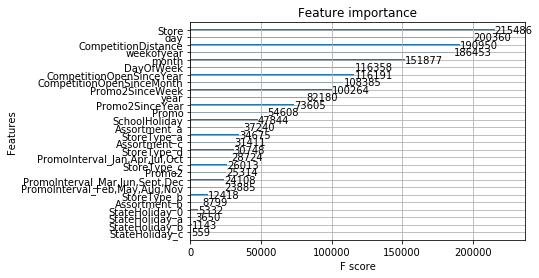

In [86]:
xgb.plot_importance(model)
pyplot.show()

In [87]:
model.save_model('rossmann.model')
dtrain.save_binary('dtrain.buffer')
dval.save_binary('dval.buffer')
dtest.save_binary('dtest.buffer')